In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pickle
import random
import gc
import json
from copy import deepcopy
import math
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import astropy.units as u
from astropy.coordinates import SkyCoord
from sklearn.metrics import accuracy_score, f1_score

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH, STORAGE_PATH
from utils import read_fits_to_pandas
from ztf import ZTF_DATES
from ml import LIMITING_MAGS, get_train_data, get_file_name
from features import FEATURES_DICT, add_colors, get_features
from sdss import read_sdss
from catalog import find_duplicates
from plotting import plot_heatmaps

/home/sjnakoneczny/tools/anaconda3/envs/py39-ztf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/sjnakoneczny/workspace/ztf-agn/notebooks/../ztf.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100
sns.set_style('ticks', {'axes.grid': False})
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

/home/sjnakoneczny/workspace/ztf-agn/notebooks/ipykernel_687628/781861970.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [4]:
ztf_date = ZTF_DATES['DR 20']
filter = 'g'

# Duplicates finish

In [ ]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

# Remove ra, dec
cols = ['n_obs', 'QSO']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [ ]:
preds_ztf.shape

(788700127, 3)

In [ ]:
# Read all files
stripe_width = 1
idx_dup = []
for x in tqdm(range(0, 360, stripe_width)):
    path_subset = 'ZTF/ZTF_{}/catalog_v2_dups/ZTF_{}_{}-band__v2__dups_ra-{}.csv'.format(ztf_date, ztf_date, filter, x)
    path_subset = os.path.join(STORAGE_PATH, path_subset)
    subset = pd.read_csv(path_subset, index_col='Unnamed: 0')
    
    dups = subset.loc[subset['is_duplicate'] == True]
    idx_dup.extend(dups.index)

  0%|          | 0/360 [00:00<?, ?it/s]

In [ ]:
len(idx_dup)

255862987

In [ ]:
preds_ztf['is_duplicate'] = False
preds_ztf.loc[idx_dup, 'is_duplicate'] = True

In [26]:
preds_ztf['is_duplicate'].sum()

255352419

In [66]:
# Test the area around RA=0/360
data_tmp = data[['ra', 'dec', 'n_obs']]

delta = 0.0003  # 1 arcsec = 000277778
subset = data_tmp.loc[(data_tmp['ra'] < delta) | (data_tmp['ra'] > 360 - delta)]

In [67]:
subset.shape

(160, 3)

In [68]:
# Find duplicates within a subset
subset = find_duplicates(subset, with_tqdm=False)

In [70]:
n_dups = subset['is_duplicate'].sum()
print('n={}\tn_dups={}\t({:.1f}%)'.format(len(subset), n_dups, n_dups/len(subset) * 100))

n=160	n_dups=41	(25.6%)


In [71]:
idx_dup = subset.loc[subset['is_duplicate'] == True].index

In [72]:
data['is_duplicate'].sum()

255352419

In [73]:
data.loc[idx_dup, 'is_duplicate'] = True

In [74]:
data['is_duplicate'].sum()

255352419

In [27]:
# Save
path_output = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_dups.csv'.format(ztf_date, ztf_date, filter)
path_output = os.path.join(STORAGE_PATH, path_output)
preds_ztf['is_duplicate'].to_csv(path_output, index=False)

# Produce the train file

In [26]:
# Read the train data
_, data = get_train_data(ztf_date=ztf_date, filter=filter, return_light_curves=False)

In [27]:
# Add lightcurve stats
file_name = 'ZTF_x_SDSS/ZTF_{}/ztf_{}_x_specObj-dr18__longests_filter_{}_reduced__stats'.format(ztf_date, ztf_date, filter)
path = os.path.join(DATA_PATH, file_name)
with open(path, 'rb') as file:
    df = pickle.load(file)
    data = pd.concat([data, df], axis=1)

In [28]:
# Get colors
data, features_dict = add_colors(data)

In [30]:
# Read Astromer preds
file_name = 'outputs/preds/ZTF_{}/ZTF_{}__band_{}__xmatch_ZTF__astromer_FC-1024-512-256'.format(ztf_date, ztf_date, filter)
file_name += '__{}.csv'
for split_label in ['train', 'val', 'test']:
    file_path = os.path.join(PROJECT_PATH, file_name.format(split_label))
    if os.path.exists(file_path):
        df_preds = pd.read_csv(file_path)
        if is_redshift:
            data.loc[data['train_split'] == split_label, 'astrm_z_qso'] = df_preds['y_pred'].to_list()
        else:
            for class_label in ['GALAXY', 'QSO', 'STAR']:
                data.loc[data['train_split'] == split_label, 'astrm_{}'.format(class_label.lower())] = df_preds[class_label].to_list()

In [35]:
# Load XGB models for classification and redshifts
tasks = ['clf', 'z']
feature_keys = {
    'clf': ['ZTF', 'AstrmClf', 'WISE'],
    'z': ['ZTF', 'WISE'],
}

models = {}
for task in tasks:
    model_file_name = get_file_name('model', task, '20240117', 'g', '_'.join(feature_keys[task]),
                                    mag_limit=False, cross_features=False,
                                    qso_vs_rest=False, n_obs_limit=False)
    file_path = os.path.join(PROJECT_PATH, model_file_name)
    with open(file_path, 'rb') as file:
        models[task] = pickle.load(file)
    print('Model read: {}'.format(file_path))

Model read: /home/sjnakoneczny/workspace/ztf-agn/outputs/models/ZTF_20240117/ZTF_20240117_band_g__features_ZTF_AstrmClf_WISE__XGB.pickle
Model read: /home/sjnakoneczny/workspace/ztf-agn/outputs/models/ZTF_20240117/ZTF_20240117_band_g__features_ZTF_WISE__XGB_z.pickle


In [37]:
for task in tasks:    
    # Prepare data
    features = get_features(features_dict, feature_keys[task], is_cross_features=False)
    X = data[features].values    

    # Run inference
    if task == 'z':
        data['xgb_z'] = models[task].predict(X)
    else:
        y_pred_proba = models[task].predict_proba(X)
        # y_pred_cls = np.argmax(y_pred_proba, axis=1)
        # data['xgb_y_pred'] = y_pred_cls
        data[['xgb_galaxy', 'xgb_qso', 'xgb_star']] = y_pred_proba

In [44]:
# Remove z_pred where no WISE features
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
nan_indices = data.index[data.isna()[wise_cols].any(axis=1)]

data.loc[nan_indices, 'xgb_z'] = np.nan

In [58]:
# Rename columns
to_save = data[['PLUG_RA', 'PLUG_DEC', 'n obs', 'mag median', 'astrm_galaxy', 'astrm_qso', 'astrm_star', 'xgb_galaxy', 'xgb_qso', 'xgb_star', 'xgb_z']]
to_save = to_save.rename(columns={
    'PLUG_RA' : 'ra',
    'PLUG_DEC' : 'dec',
    'n obs': 'n_obs',
    'mag_median': 'mag median',
    'astrm_galaxy': 'p_galaxy',
    'astrm_qso': 'p_QSO',
    'astrm_star': 'p_star',
    'xgb_galaxy': 'p_WISE_galaxy',
    'xgb_qso': 'p_WISE_QSO',
    'xgb_star': 'p_WISE_star',
    'zgb_z': 'redshift',
})

In [59]:
# Save DF
to_save.to_csv(os.path.join(STORAGE_PATH, 'ZTF/ZTF_20240117/published/train.csv'), index=False)

# Produce the catalog files

In [5]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

cols = ['CLASS']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [6]:
# Read XGB predictions
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_pred']
preds_xgb = pd.read_csv(path_xgb, usecols=cols)

In [7]:
# Get only QSOs
idx = (preds_ztf['CLASS'] == 1) | (preds_xgb['y_pred'] == 1)

In [8]:
# Skip reading objects not classified as QSOs
skiprows = np.where(~idx)[0] + 1

In [9]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

cols = ['id', 'ra', 'dec', 'n_obs', 'mag_median', 'GALAXY', 'QSO', 'STAR', 'CLASS']
preds_ztf = pd.read_csv(path_ztf, usecols=cols, skiprows=skiprows)

In [10]:
# Read ZTF duplicates
path_dups = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_dups.csv'.format(ztf_date, ztf_date, filter)
path_dups = os.path.join(STORAGE_PATH, path_dups)

cols = ['is_duplicate']
preds_dups = pd.read_csv(path_dups, usecols=cols, skiprows=skiprows)

In [11]:
# Read XGB predictions
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_pred', 'y_galaxy', 'y_qso', 'y_star', 'z_pred']
preds_xgb = pd.read_csv(path_xgb, usecols=cols, skiprows=skiprows)

In [12]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols, skiprows=skiprows)

In [13]:
data = pd.concat([preds_ztf, preds_dups, preds_xgb, preds_wise], axis=1)
data = data.reset_index(drop=True)

In [21]:
# Remove z_pred where no WISE features
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
nan_indices = data.index[data.isna()[wise_cols].any(axis=1)]

data.loc[nan_indices, 'z_pred'] = np.nan

In [14]:
data.shape

(78078450, 19)

In [15]:
data['is_duplicate'].sum()

20109860

In [20]:
# Duplicates flag
20109860 / 78078450

0.25755967235517613

## All QSO file

In [24]:
# Rename columns
to_save = data[['id', 'ra', 'dec', 'n_obs', 'is_duplicate', 'mag_median', 'GALAXY', 'QSO', 'STAR', 'y_galaxy', 'y_qso', 'y_star', 'z_pred']]
to_save = to_save.rename(columns={
    'id': 'ID',
    'GALAXY': 'p_galaxy',
    'QSO': 'p_QSO',
    'STAR': 'p_star',
    'y_galaxy': 'p_WISE_galaxy',
    'y_qso': 'p_WISE_QSO',
    'y_star': 'p_WISE_star',
    'z_pred': 'redshift',
})

In [33]:
# Save
to_save.to_csv(os.path.join(STORAGE_PATH, 'ZTF/ZTF_20240117/published/ZTF_all_QSO.csv'), index=False)

In [25]:
to_save

,ID,ra,dec,n_obs,is_duplicate,mag_median,p_galaxy,p_QSO,p_star,p_WISE_galaxy,p_WISE_QSO,p_WISE_star,redshift
0,10202361000000,24.985956,-29.608840,25,False,20.167160,0.376623,0.524051,0.099327,0.228304,0.769908,0.001788,1.089791
1,10202361000104,25.478681,-29.638601,42,False,19.588265,0.292211,0.437916,0.269873,0.103044,0.007657,0.889298,3.310030
2,10202361000185,25.661731,-29.663325,25,False,20.119190,0.380711,0.539252,0.080038,0.221202,0.772406,0.006391,3.132066
3,10202361000253,25.379980,-29.688877,39,False,20.015670,0.570643,0.291449,0.137909,0.241620,0.641579,0.116800,2.491261
4,10202361000343,25.782600,-29.726787,28,False,20.409875,0.688552,0.162452,0.148996,0.258913,0.520634,0.220453,2.671818
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78078445,11896431013707,80.460274,87.591016,32,False,19.842533,0.403693,0.486069,0.110238,0.836497,0.006176,0.157327,2.131061
78078446,11896431014005,82.954549,87.533155,51,False,19.414820,0.264420,0.666562,0.069018,0.087396,0.007050,0.905555,2.231115
78078447,11896431014215,70.661432,87.350544,46,True,19.593515,0.266572,0.565948,0.167480,0.029337,0.003759,0.966904,3.744129
78078448,11896431016473,73.560793,87.382688,49,True,19.286745,0.027670,0.901120,0.071211,0.021424,0.001159,0.977417,5.177319


## QZO file

In [34]:
# Get the QZO
qzo = data.loc[data['y_qso'] > 0.9]
qzo = qzo.loc[qzo['is_duplicate'] == False]

qzo['is_custom'] = qzo['mag_median'] < (qzo['n_obs'] / 80 + 20.375)
qzo = qzo.loc[qzo['is_custom'] == True]

qzo = qzo.reset_index(drop=True)

In [35]:
qzo.shape

(4849574, 20)

In [40]:
qzo['z_pred'].isna().sum()

3157137

In [42]:
1 - 3157137 / 4849574

0.34898673574214967

In [43]:
# Rename columns
to_save = qzo[['id', 'ra', 'dec', 'n_obs', 'mag_median', 'GALAXY', 'QSO', 'STAR', 'y_galaxy', 'y_qso', 'y_star', 'z_pred']]
to_save = to_save.rename(columns={
    'id': 'ID',
    'GALAXY': 'p_galaxy',
    'QSO': 'p_QSO',
    'STAR': 'p_star',
    'y_galaxy': 'p_WISE_galaxy',
    'y_qso': 'p_WISE_QSO',
    'y_star': 'p_WISE_star',
    'z_pred': 'redshift',
})

In [45]:
# Save
to_save.to_csv(os.path.join(STORAGE_PATH, 'ZTF/ZTF_20240117/published/QZO.csv'), index=False)

In [44]:
to_save

,ID,ra,dec,n_obs,mag_median,p_galaxy,p_QSO,p_star,p_WISE_galaxy,p_WISE_QSO,p_WISE_star,redshift
0,10202361000706,25.764548,-29.881832,82,18.599430,0.005694,0.977986,0.016321,0.001310,0.997978,0.000712,2.067709
1,10202361000727,25.644028,-29.891646,47,19.717270,0.457347,0.258736,0.283918,0.010979,0.988165,0.000856,2.026701
2,10202361000740,25.542810,-29.898190,34,20.061275,0.005294,0.993910,0.000797,0.000138,0.999782,0.000080,2.252488
3,10202361000807,25.032535,-29.931152,44,19.915520,0.210417,0.683332,0.106250,0.004803,0.993133,0.002064,1.022533
4,10202361000808,25.268425,-29.929151,22,20.474525,0.169647,0.802645,0.027708,0.001696,0.998043,0.000261,2.068923
...,...,...,...,...,...,...,...,...,...,...,...,...
4849569,11896431000414,76.769793,88.218469,44,19.592375,0.083089,0.898194,0.018717,0.009029,0.975875,0.015096,2.911648
4849570,11896431003519,71.430276,87.684710,38,19.782422,0.272752,0.596693,0.130555,0.002634,0.997049,0.000317,1.385970
4849571,11896431004662,83.789953,87.633756,36,19.940110,0.259038,0.589400,0.151562,0.024920,0.973525,0.001556,0.671892
4849572,11896431005012,87.070715,87.594205,40,19.676725,0.523283,0.430226,0.046491,0.009629,0.990118,0.000253,1.284373


# Validation

## WISE

In [7]:
# Read the train data
_, data = get_train_data(ztf_date=ztf_date, filter=filter, return_light_curves=False)

In [8]:
# Add lightcurve stats
file_name = 'ZTF_x_SDSS/ZTF_{}/ztf_{}_x_specObj-dr18__longests_filter_{}_reduced__stats'.format(
    ztf_date, ztf_date, filter)
path = os.path.join(DATA_PATH, file_name)
with open(path, 'rb') as file:
    df = pickle.load(file)
    data = pd.concat([data, df], axis=1)

In [9]:
# Get colors
data, features_dict = add_colors(data)

In [17]:
# Add Astromer as features
file_name = 'outputs/preds/ZTF_{}/ZTF_{}__band_{}__xmatch_ZTF__astromer_FC-1024-512-256'.format(
    ztf_date, ztf_date, filter)
file_name += '__{}.csv'
for split_label in ['train', 'val', 'test']:
    file_path = os.path.join(PROJECT_PATH, file_name.format(split_label))
    if os.path.exists(file_path):
        df_preds = pd.read_csv(file_path)
        for class_label in ['GALAXY', 'QSO', 'STAR']:
            data.loc[data['train_split'] == split_label, 'astrm_{}'.format(class_label.lower())] = df_preds[class_label].to_list()

In [59]:
# Load the classification model
task = 'clf'
feature_keys = ['ZTF', 'AstrmClf', 'WISE']
model_file_name = get_file_name('model', task, '20240117', 'g', '_'.join(feature_keys),
                                mag_limit=False, cross_features=False,
                                qso_vs_rest=False, n_obs_limit=False)
file_path = os.path.join(PROJECT_PATH, model_file_name)
with open(file_path, 'rb') as file:
    model = pickle.load(file)
print('Model read: {}'.format(file_path))

Model read: /home/sjnakoneczny/workspace/ztf-agn/outputs/models/ZTF_20240117/ZTF_20240117_band_g__features_ZTF_AstrmClf_WISE__XGB.pickle


In [60]:
features = get_features(features_dict, feature_keys)

### All data

In [18]:
# Extract features
X = data[features].values

In [20]:
preds = model.predict(X)

In [23]:
cls_dict = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}
preds = [cls_dict[x] for x in preds]

In [25]:
print('Acc: {:.2f}'.format(accuracy_score(data['CLASS'], preds)))
print('F1: ', np.round(f1_score(data['CLASS'], preds, average=None), 2))

Acc: 0.94
F1:  [0.95 0.94 0.93]


### WISE data

In [27]:
# Take only WISE subset
data_wise = data.dropna(subset=FEATURES_DICT['WISE'])

In [30]:
X = data_wise[features].values

In [31]:
preds = model.predict(X)

In [32]:
cls_dict = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}
preds = [cls_dict[x] for x in preds]

In [34]:
print('Acc: {:.2f}'.format(accuracy_score(data_wise['CLASS'], preds)))
print('F1: ', np.round(f1_score(data_wise['CLASS'], preds, average=None), 2))

Acc: 0.97
F1:  [0.98 0.98 0.96]


### WISE but removed

In [37]:
X[:, 4:] = np.nan

In [40]:
preds = model.predict(X)

In [41]:
cls_dict = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}
preds = [cls_dict[x] for x in preds]

In [42]:
print('Acc: {:.2f}'.format(accuracy_score(data_wise['CLASS'], preds)))
print('F1: ', np.round(f1_score(data_wise['CLASS'], preds, average=None), 2))

Acc: 0.83
F1:  [0.85 0.86 0.79]


### Non WISE data

In [43]:
# Take only WISE subset
data_non_wise = data[data[FEATURES_DICT['WISE']].isna().any(axis=1)]

In [45]:
X = data_non_wise[features].values

In [46]:
preds = model.predict(X)

In [47]:
cls_dict = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}
preds = [cls_dict[x] for x in preds]

In [48]:
print('Acc: {:.2f}'.format(accuracy_score(data_non_wise['CLASS'], preds)))
print('F1: ', np.round(f1_score(data_non_wise['CLASS'], preds, average=None), 2))

Acc: 0.83
F1:  [0.73 0.84 0.87]


### WISE with ZTF model

In [53]:
# Load the classification model
task = 'clf'
feature_keys = ['ZTF', 'AstrmClf']
model_file_name = get_file_name('model', task, '20240117', 'g', '_'.join(feature_keys),
                                mag_limit=False, cross_features=False,
                                qso_vs_rest=False, n_obs_limit=False)
file_path = os.path.join(PROJECT_PATH, model_file_name)
with open(file_path, 'rb') as file:
    model = pickle.load(file)
print('Model read: {}'.format(file_path))

Model read: /home/sjnakoneczny/workspace/ztf-agn/outputs/models/ZTF_20240117/ZTF_20240117_band_g__features_ZTF_AstrmClf__XGB.pickle


In [54]:
# Take only WISE subset
data_wise = data.dropna(subset=FEATURES_DICT['WISE'])

In [55]:
features = get_features(features_dict, feature_keys)
X = data_wise[features].values

In [56]:
preds = model.predict(X)

In [57]:
cls_dict = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}
preds = [cls_dict[x] for x in preds]

In [58]:
print('Acc: {:.2f}'.format(accuracy_score(data_wise['CLASS'], preds)))
print('F1: ', np.round(f1_score(data_wise['CLASS'], preds, average=None), 2))

Acc: 0.92
F1:  [0.94 0.91 0.91]


## Get cross-match

In [5]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

cols = ['ra', 'dec', 'n_obs', 'mag median', 'CLASS']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [6]:
# Read SDSS
columns = ['PLUG_RA', 'PLUG_DEC', 'CLASS', 'Z', 'ZWARNING']
data_sdss = read_sdss(dr=18, clean=True, columns=columns)

Original SDSS: 5261255
Cleaning SDSS: 4398710


In [7]:
# Build positions
positions_ztf = SkyCoord(
    ra=preds_ztf['ra'].to_numpy() * u.degree,
    dec=preds_ztf['dec'].to_numpy() * u.degree,
)
positions_sdss = SkyCoord(
    ra=data_sdss['PLUG_RA'].to_numpy() * u.degree,
    dec=data_sdss['PLUG_DEC'].to_numpy() * u.degree,
)

In [8]:
# Run cross-match
idx_sdss, idx_ztf, sep_2d, dist_3d = positions_ztf.search_around_sky(positions_sdss, 1 * u.arcsec)

In [9]:
# Get indices of the longests matches
cross_idx = pd.DataFrame({'idx_sdss': idx_sdss, 'idx_ztf': idx_ztf})
cross_idx['n_obs'] = preds_ztf.loc[idx_ztf]['n_obs'].reset_index(drop=True)
longests_idx = cross_idx.loc[cross_idx.groupby(['idx_sdss'])['n_obs'].idxmax()]

In [10]:
# Get the final cross-match indices
idx_ztf = longests_idx['idx_ztf'].to_list()
idx_sdss = longests_idx['idx_sdss'].to_list()

In [11]:
# Read XGB predictions
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_pred', 'z_pred']
preds_xgb = pd.read_csv(path_xgb, usecols=cols)

In [12]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols)

In [13]:
# Build cross-matched DF
tmp_ztf = preds_ztf.loc[idx_ztf].reset_index(drop=True)
tmp_xgb = preds_xgb.loc[idx_ztf].reset_index(drop=True)
tmp_wise = preds_wise.loc[idx_ztf].reset_index(drop=True)
tmp_sdss = data_sdss.loc[idx_sdss].reset_index(drop=True)

preds = pd.concat([tmp_ztf, tmp_xgb, tmp_wise], axis=1)

preds = preds.join(tmp_sdss, lsuffix='_ZTF', rsuffix='_SDSS')

# Change labels back to strings
cls_dict = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}
preds['CLASS_ZTF'] = preds['CLASS_ZTF'].apply(lambda x: cls_dict[x])
preds['y_pred'] = preds['y_pred'].apply(lambda x: cls_dict[x])

In [14]:
# Non WISE subset
preds_wise = preds.dropna(subset=FEATURES_DICT['WISE'])
preds_non_wise = preds.loc[~preds.index.isin(preds_wise.index)].reset_index(drop=True)
preds_wise = preds_wise.reset_index(drop=True)

## Classification

In [15]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds['CLASS_SDSS'], preds['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds['CLASS_SDSS'], preds['CLASS_ZTF'], average=None), 2))

Acc: 0.88
F1:  [0.89 0.88 0.87]


In [16]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds['CLASS_SDSS'], preds['y_pred'])))
print('F1: ', np.round(f1_score(preds['CLASS_SDSS'], preds['y_pred'], average=None), 2))

Acc: 0.94
F1:  [0.95 0.94 0.92]


In [17]:
# Subsets
preds_cut = preds.loc[preds['mag median'] < preds['n_obs'] / 80 + 20.375]

In [18]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_cut['CLASS_SDSS'], preds_cut['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds_cut['CLASS_SDSS'], preds_cut['CLASS_ZTF'], average=None), 2))

Acc: 0.91
F1:  [0.91 0.93 0.89]


In [19]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_cut['CLASS_SDSS'], preds_cut['y_pred'])))
print('F1: ', np.round(f1_score(preds_cut['CLASS_SDSS'], preds_cut['y_pred'], average=None), 2))

Acc: 0.96
F1:  [0.96 0.96 0.94]


In [20]:
# Subsets
preds_cut = preds.loc[(preds['mag median'] < 20.8) & (preds['n_obs'] > 100)]

In [21]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_cut['CLASS_SDSS'], preds_cut['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds_cut['CLASS_SDSS'], preds_cut['CLASS_ZTF'], average=None), 2))

Acc: 0.96
F1:  [0.96 0.96 0.94]


In [22]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_cut['CLASS_SDSS'], preds_cut['y_pred'])))
print('F1: ', np.round(f1_score(preds_cut['CLASS_SDSS'], preds_cut['y_pred'], average=None), 2))

Acc: 0.98
F1:  [0.98 0.98 0.97]


In [23]:
# WISE subset

In [24]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_wise['CLASS_SDSS'], preds_wise['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds_wise['CLASS_SDSS'], preds_wise['CLASS_ZTF'], average=None), 2))

Acc: 0.92
F1:  [0.93 0.9  0.9 ]


In [25]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_wise['CLASS_SDSS'], preds_wise['y_pred'])))
print('F1: ', np.round(f1_score(preds_wise['CLASS_SDSS'], preds_wise['y_pred'], average=None), 2))

Acc: 0.97
F1:  [0.98 0.98 0.96]


In [26]:
# Non WISE subset

In [27]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_non_wise['CLASS_SDSS'], preds_non_wise['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds_non_wise['CLASS_SDSS'], preds_non_wise['CLASS_ZTF'], average=None), 2))

Acc: 0.77
F1:  [0.67 0.81 0.81]


In [28]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_non_wise['CLASS_SDSS'], preds_non_wise['y_pred'])))
print('F1: ', np.round(f1_score(preds_non_wise['CLASS_SDSS'], preds_non_wise['y_pred'], average=None), 2))

Acc: 0.83
F1:  [0.73 0.84 0.87]


## Redshift

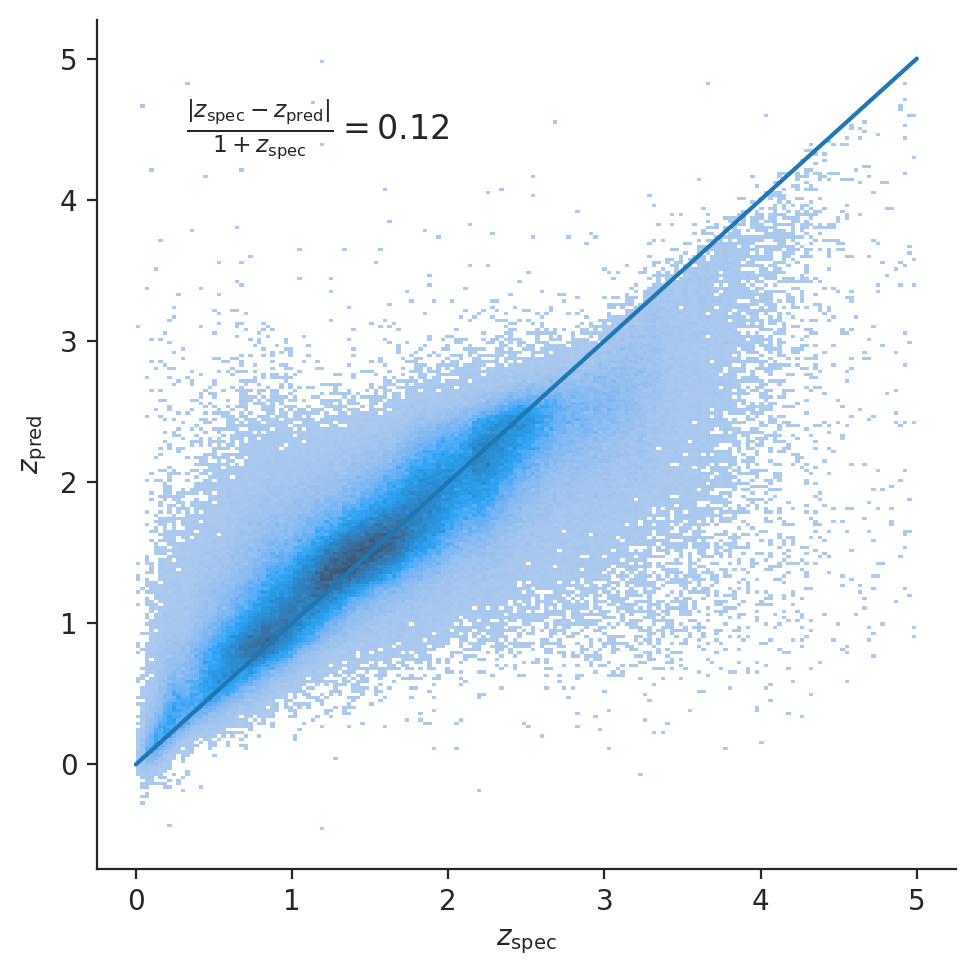

In [29]:
# Redshift validation
preds_qso = preds.loc[preds['CLASS_SDSS'] == 'QSO']
preds_qso_wise = preds_qso.dropna(subset=FEATURES_DICT['WISE']).reset_index(drop=True)

z_max = 5
preds_qso_wise = preds_qso_wise.loc[(preds_qso_wise['Z'] < z_max) & (preds_qso_wise['z_pred'] < z_max)]

z_true = preds_qso_wise['Z']
z_pred = preds_qso_wise['z_pred']
z_err = np.mean(abs(z_true - z_pred) / (1 + z_true))

ax = sns.displot(x=z_true, y=z_pred)
plt.plot(range(z_max + 1), range(z_max + 1), '-')

text = '$\\frac{|z_{\mathrm{spec}} - z_{\mathrm{pred}}|}{1 + z_{\mathrm{spec}}} = ' + str(np.round(z_err, 2)) + '$'
ax.fig.text(0.2, 0.85, text, fontsize='large')

ax.set_xlabels('$z_{\mathrm{spec}}$')
ax.set_ylabels('$z_{\mathrm{pred}}$')

plt.tight_layout()
plt.show()

# Stats

## WISE train vs inference coverage

In [5]:
# Read the train data
_, data_train = get_train_data(ztf_date=ztf_date, filter=filter, return_light_curves=False)

In [7]:
data_train.columns

Index(['PLUG_RA', 'PLUG_DEC', 'CLASS', 'SUBCLASS', 'Z', 'Z_ERR', 'ZWARNING',
       'PS1_DR1__gMeanPSFMag', 'PS1_DR1__rMeanPSFMag', 'PS1_DR1__iMeanPSFMag',
       'PS1_DR1__zMeanPSFMag', 'AllWISE__w1mpro', 'AllWISE__w2mpro',
       'AllWISE__w3mpro', 'AllWISE__w4mpro', 'Gaia_EDR3__phot_g_mean_mag',
       'Gaia_EDR3__phot_bp_mean_mag', 'Gaia_EDR3__phot_rp_mean_mag',
       'Gaia_EDR3__phot_bp_rp_excess_factor',
       'Gaia_EDR3__astrometric_excess_noise', 'Gaia_EDR3__parallax',
       'Gaia_EDR3__parallax_error', 'Gaia_EDR3__pmra', 'Gaia_EDR3__pmra_error',
       'Gaia_EDR3__pmdec', 'Gaia_EDR3__pmdec_error', 'train_split'],
      dtype='object')

In [12]:
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
1 - data_train[wise_cols].isna().any(axis=1).sum() / data_train.shape[0]

0.7718757401319285

In [13]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols)

In [14]:
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
1 - preds_wise[wise_cols].isna().any(axis=1).sum() / preds_wise.shape[0]

0.4093536731483245

## Magnitude and n_obs train vs inference coverage

In [5]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

# Remove ra, dec
cols = ['n_obs', 'mag_median', 'CLASS', 'QSO']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [6]:
preds_ztf.shape

(788700127, 4)

In [33]:
preds_sampled = preds_ztf.sample(n=388234)  # Size of g-band test data

In [34]:
# QSO F1 on a 2D plot
mag_step = 0.25
n_obs_step = 20

n_qzo = []
n_qso = []
n_obj = []

mags = preds_sampled['mag_median']
n_obs = preds_sampled['n_obs']

for mag_center in tqdm(np.arange(14, mags.max() + mag_step, mag_step)):
    mag_max = mag_center + mag_step / 2
    mag_min = mag_center - mag_step / 2

    for n_obs_center in range(30, 200 + n_obs_step, n_obs_step):
        n_obs_max = n_obs_center + n_obs_step / 2
        n_obs_min = n_obs_center - n_obs_step / 2

        subset = preds_sampled.loc[
            (mags < mag_max) & 
            (mags > mag_min) & 
            (n_obs <= n_obs_max) &
            (n_obs >= n_obs_min)
        ]

        subset_qso = subset.loc[subset['CLASS'] == 1]
        n_qso_tmp = len(subset_qso)
        
        subset_qzo = subset.loc[subset['QSO'] > 0.9]
        n_qzo_tmp = len(subset_qzo)
        
        n_obj_tmp = len(subset)

        if n_qso_tmp > 100:
            n_qso.append((mag_center, n_obs_center, n_qso_tmp))
            n_qzo.append((mag_center, n_obs_center, n_qzo_tmp))
            n_obj.append((mag_center, n_obs_center, n_obj_tmp))
        else:
            n_qso.append((mag_center, n_obs_center, np.nan))
            n_qzo.append((mag_center, n_obs_center, np.nan))
            n_obj.append((mag_center, n_obs_center, np.nan))

  0%|          | 0/34 [00:00<?, ?it/s]

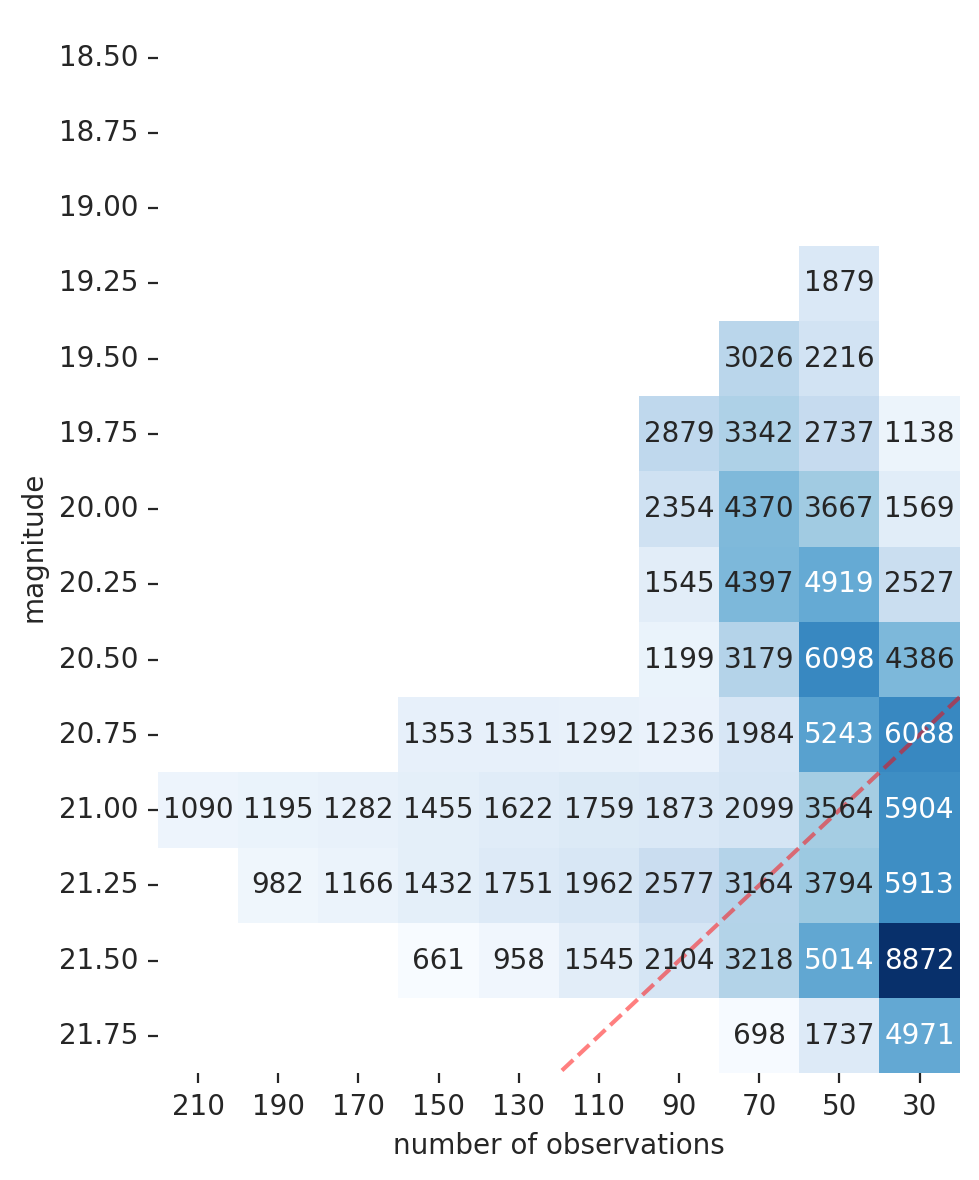

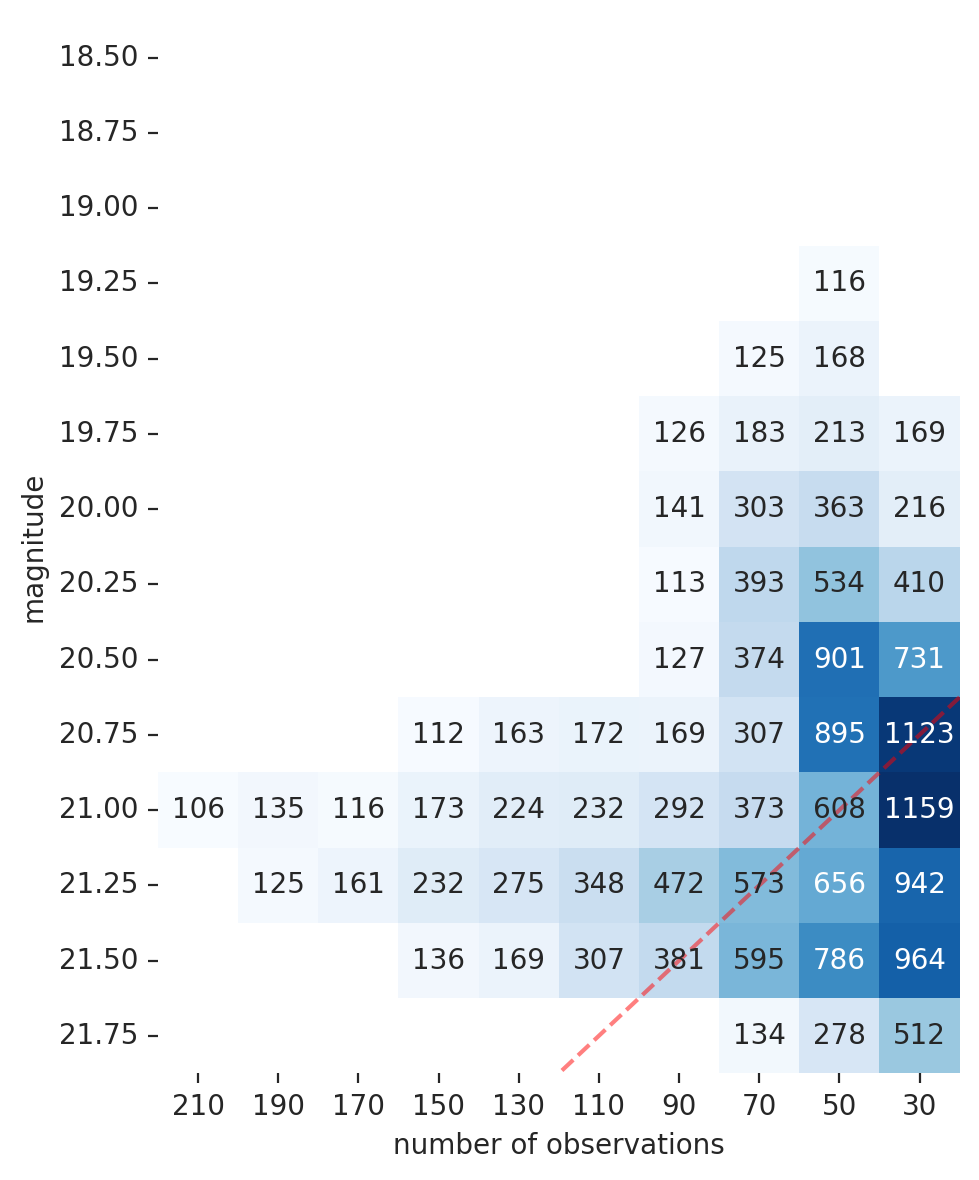

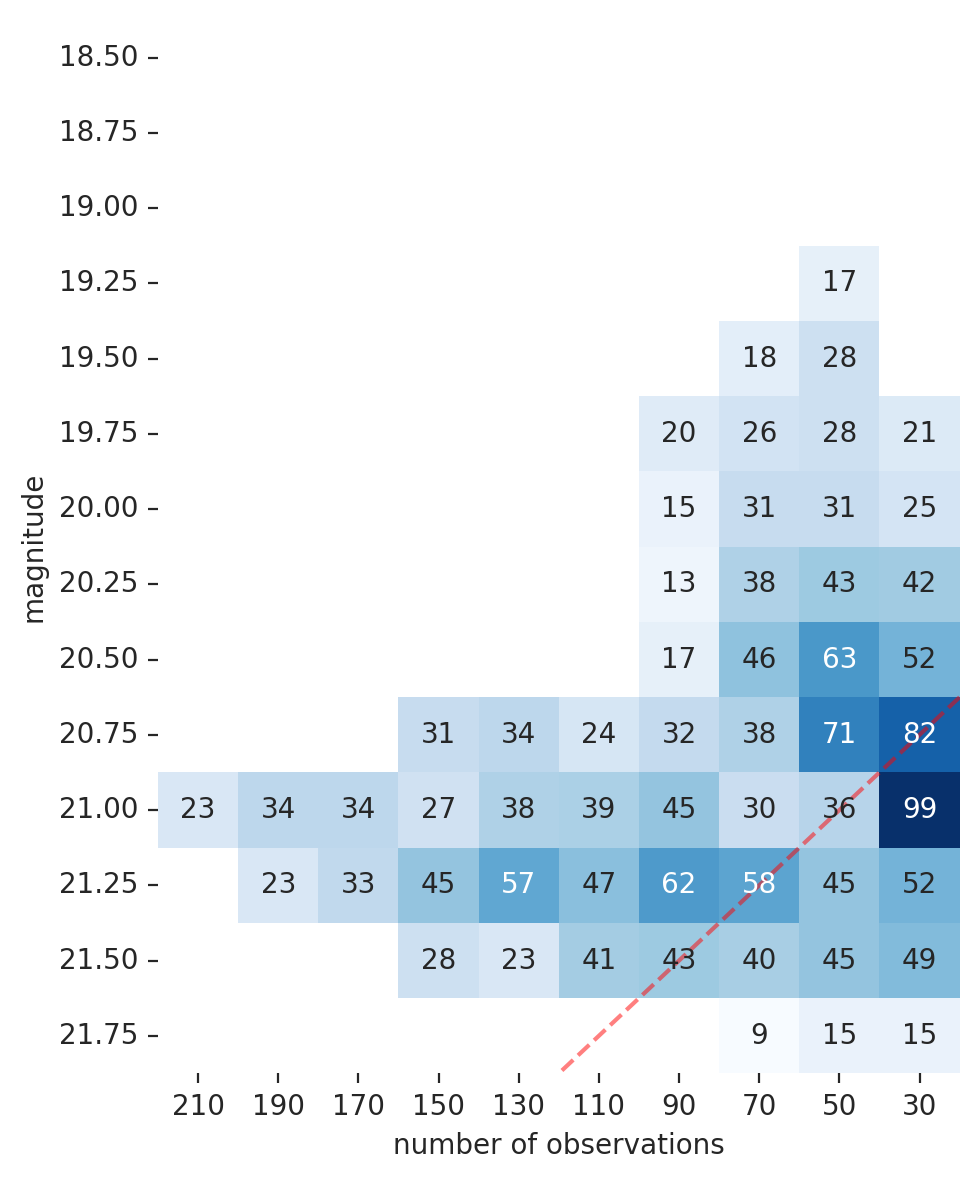

In [35]:
to_plot = [
    ({'g': n_obj}, 'number of objects'),
    ({'g': n_qso}, 'number of QSOs'),
    ({'g': n_qzo}, 'number of QZOs'),
]
plot_heatmaps(to_plot)

# Counts

In [5]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

cols = ['n_obs', 'mag_median', 'CLASS', 'QSO']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [6]:
# Size of the full inference set
preds_ztf.shape

(788700127, 4)

In [7]:
# Read ZTF duplicates
path_dups = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_dups.csv'.format(ztf_date, ztf_date, filter)
path_dups = os.path.join(STORAGE_PATH, path_dups)

cols = ['is_duplicate']
preds_dups = pd.read_csv(path_dups, usecols=cols)

In [8]:
preds_dups['is_duplicate'].sum()

255352419

In [9]:
# Read WISE preds
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_pred', 'y_qso', 'z_pred']
preds_xgb = pd.read_csv(path_xgb, usecols=cols)

In [10]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols)

In [11]:
idx_qso = (preds_ztf['CLASS'] == 1) | (preds_xgb['y_pred'] == 1)

In [12]:
# Merge all in little turns
qso = preds_ztf[idx_qso].join(preds_dups[idx_qso])
preds_ztf = 0
preds_dups = 0
gc.collect()

0

In [13]:
qso = qso.join(preds_xgb[idx_qso])
preds_xgb = 0
gc.collect()

0

In [14]:
qso = qso.join(preds_wise[idx_qso])
preds_wise = 0
gc.collect()

0

In [15]:
qso = qso.reset_index(drop=True)

In [16]:
# Add cuts
qso['is_n_obs'] = qso['n_obs'] > 100
qso['is_mag'] = qso['mag_median'] < LIMITING_MAGS['g']
qso['is_custom'] = qso['mag_median'] < (qso['n_obs'] / 80 + 20.375)

In [17]:
qso_dedup = qso.loc[qso['is_duplicate'] == False]

In [18]:
# Switch names
qso_dup = qso
qso = qso_dedup

## XGB one WISE vs combo

In [43]:
qzo = qso.loc[qso['is_custom']].reset_index(drop=True)

In [44]:
qzo.loc[qzo['QSO'] > 0.9].shape

(5331887, 15)

In [45]:
qzo.loc[qzo['y_qso'] > 0.9].shape

(4849574, 15)

In [46]:
qzo.loc[(qzo['QSO'] > 0.9) & (qzo['y_qso'] > 0.9)].shape

(3976043, 15)

In [47]:
cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
nan_mask = qzo[cols].isna().any(axis=1)

In [48]:
qzo.loc[nan_mask & (qzo['QSO'] > 0.9)].shape

(3464689, 15)

In [49]:
qzo.loc[nan_mask & (qzo['y_qso'] > 0.9)].shape

(3157137, 15)

In [50]:
qzo.loc[nan_mask & (qzo['QSO'] > 0.9) & (qzo['y_qso'] > 0.9)].shape

(2808580, 15)

In [15]:
3464689 - 3157137

307552

In [16]:
3464689 - 2808580

656109

## Final

In [26]:
# Add combo preds
cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
nan_mask = qso[cols].isna().any(axis=1)

qso.loc[nan_mask, 'y_pred_combo'] = qso.loc[nan_mask, 'QSO']
qso.loc[~nan_mask, 'y_pred_combo'] = qso.loc[~nan_mask, 'y_qso']

qso.loc[nan_mask, 'CLASS_combo'] = qso.loc[nan_mask, 'CLASS']
qso.loc[~nan_mask, 'CLASS_combo'] = qso.loc[~nan_mask, 'y_pred']

In [30]:
qso.shape

(78078450, 19)

In [31]:
qso_dedup.shape

(57968590, 19)

In [32]:
qso['is_duplicate'].sum()

20109860

In [39]:
# Get QSO subsets
qso_ztf = qso_dedup.loc[qso_dedup['CLASS'] == 1]
qso_wise = qso_dedup.loc[qso_dedup['y_pred'] == 1]
qso_combo = qso_dedup.loc[qso_dedup['CLASS_combo'] == 1]

In [36]:
qso_ztf.shape

(35538007, 19)

In [37]:
qso_wise.shape

(45927239, 19)

In [40]:
qso_combo.shape

(34176854, 19)

In [41]:
# Initialize statistics
p_min_arr = np.array([x / 100 for x in range(0, 100, 1)])
n_qso = defaultdict(list)

In [42]:
# Calculate ZTF counts
for p_min in tqdm(p_min_arr):
    tmp = qso_ztf.loc[qso_ztf['QSO'] > p_min]
    n_qso['ZTF all'].append(tmp.shape[0])
    n_qso['ZTF or'].append(tmp.loc[tmp['is_mag'] | tmp['is_n_obs']].shape[0])
    n_qso['ZTF mag'].append(tmp.loc[tmp['is_mag']].shape[0])
    n_qso['ZTF obs'].append(tmp.loc[tmp['is_n_obs']].shape[0])
    n_qso['ZTF and'].append(tmp.loc[tmp['is_mag'] & tmp['is_n_obs']].shape[0])
    n_qso['ZTF custom'].append(tmp.loc[tmp['is_custom']].shape[0])
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
# Calculate WISE counts
for p_min in tqdm(p_min_arr):
    tmp = qso_wise.loc[qso_wise['y_qso'] > p_min]
    n_qso['WISE all'].append(tmp.shape[0])
    n_qso['WISE or'].append(tmp.loc[tmp['is_mag'] | tmp['is_n_obs']].shape[0])
    n_qso['WISE mag'].append(tmp.loc[tmp['is_mag']].shape[0])
    n_qso['WISE obs'].append(tmp.loc[tmp['is_n_obs']].shape[0])
    n_qso['WISE and'].append(tmp.loc[tmp['is_mag'] & tmp['is_n_obs']].shape[0])
    n_qso['WISE custom'].append(tmp.loc[tmp['is_custom']].shape[0])
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
# Calculate combo counts
for p_min in tqdm(p_min_arr):
    tmp = qso_combo.loc[qso_combo['y_pred_combo'] > p_min]
    n_qso['combo all'].append(tmp.shape[0])
    n_qso['combo or'].append(tmp.loc[tmp['is_mag'] | tmp['is_n_obs']].shape[0])
    n_qso['combo mag'].append(tmp.loc[tmp['is_mag']].shape[0])
    n_qso['combo obs'].append(tmp.loc[tmp['is_n_obs']].shape[0])
    n_qso['combo and'].append(tmp.loc[tmp['is_mag'] & tmp['is_n_obs']].shape[0])
    n_qso['combo custom'].append(tmp.loc[tmp['is_custom']].shape[0])
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

ZTF all 6124844
ZTF custom 5331887
ZTF or 4956997
ZTF obs 4071301
ZTF mag 3291338
ZTF and 2405642


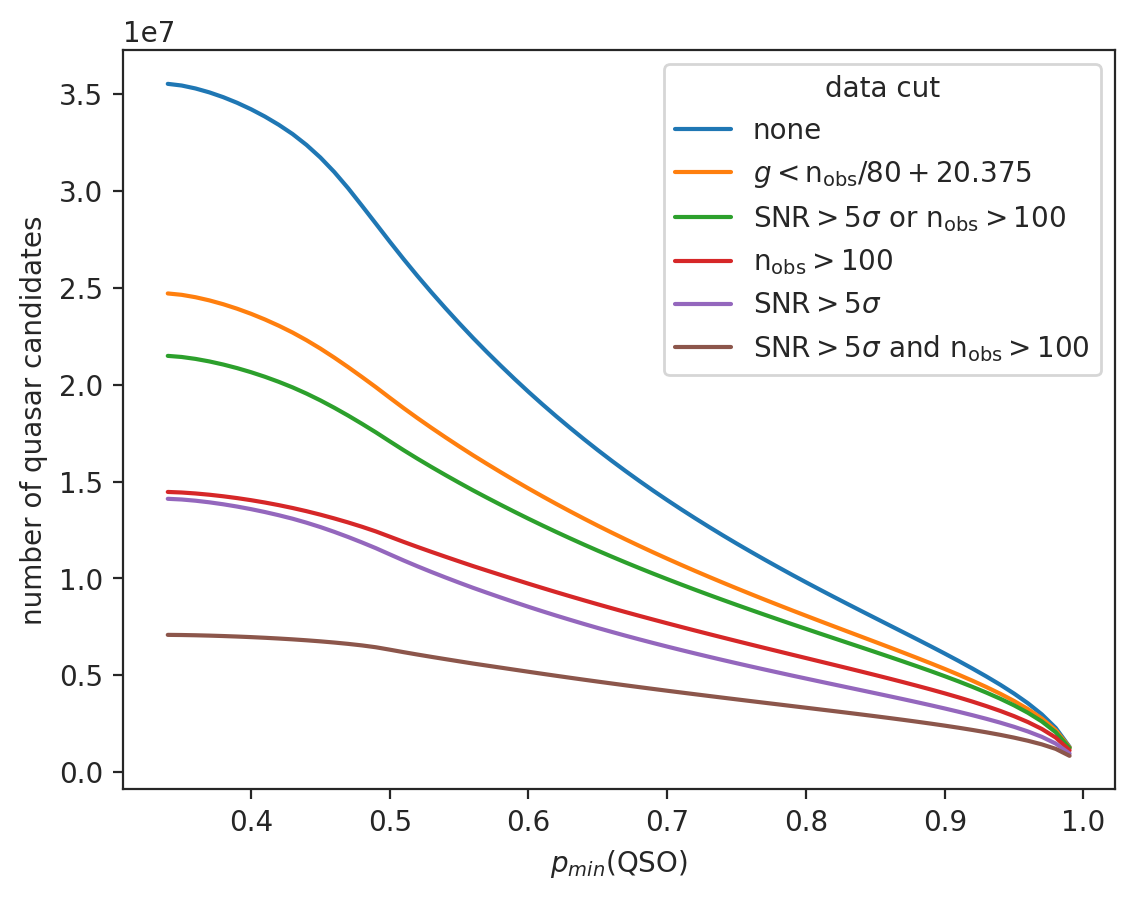

In [34]:
# ZTF counts
idx = np.where(p_min_arr > 1/3)[0][0]

labels = {
    'ZTF all': 'none',
    'ZTF custom': '$g < \mathrm{n_{obs}} / 80 + 20.375$',
    'ZTF or': '$\mathrm{SNR} > 5\sigma \mathrm{\ or\ } \mathrm{n_{obs}} > 100$',
    'ZTF obs': '$\mathrm{n_{obs}} > 100$',
    'ZTF mag': '$\mathrm{SNR} > 5\sigma$',
    'ZTF and': '$\mathrm{SNR} > 5\sigma \mathrm{\ and\ } \mathrm{n_{obs}} > 100$',
}
for key in labels:
    print(key, n_qso[key][90])
    plt.plot(p_min_arr[idx:], n_qso[key][idx:], label=labels[key])

plt.legend(title='data cut')
plt.xlabel('$p_{min}(\mathrm{QSO})$')
plt.ylabel('number of quasar candidates')
plt.show()

WISE all 6644605
WISE custom 4849574
WISE or 4284010
WISE obs 3529222
WISE mag 2468580
WISE and 1713792


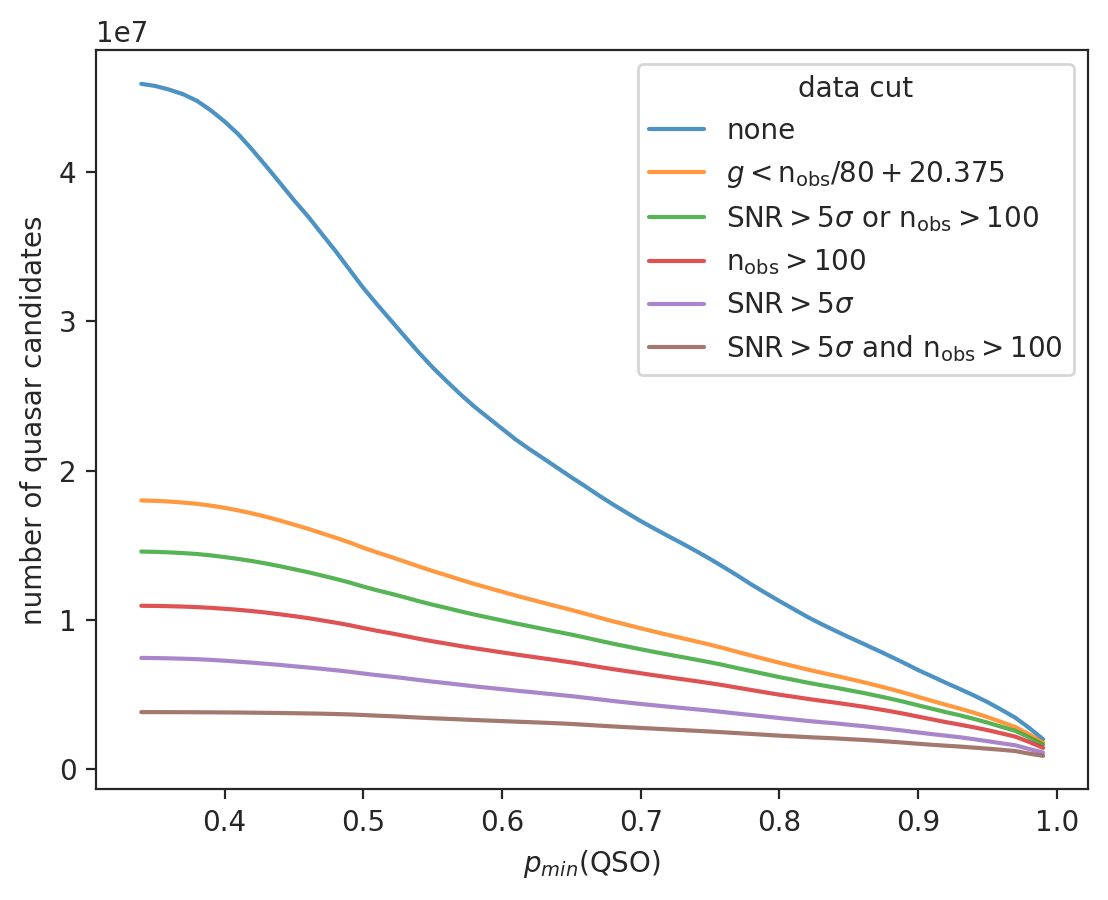

In [35]:
# WISE counts
idx = np.where(p_min_arr > 1/3)[0][0]

labels = {
    'WISE all': 'none',
    'WISE custom': '$g < \mathrm{n_{obs}} / 80 + 20.375$',
    'WISE or': '$\mathrm{SNR} > 5\sigma \mathrm{\ or\ } \mathrm{n_{obs}} > 100$',
    'WISE obs': '$\mathrm{n_{obs}} > 100$',
    'WISE mag': '$\mathrm{SNR} > 5\sigma$',
    'WISE and': '$\mathrm{SNR} > 5\sigma \mathrm{\ and\ } \mathrm{n_{obs}} > 100$',
}
for key in labels:
    print(key, n_qso[key][90])
    plt.plot(p_min_arr[idx:], n_qso[key][idx:], label=labels[key], alpha=0.8)

plt.legend(title='data cut')
plt.xlabel('$p_{min}(\mathrm{QSO})$')
plt.ylabel('number of quasar candidates')
plt.show()

WISE custom 4849574
WISE or 4284010
WISE obs 3529222
WISE mag 2468580
WISE and 1713792


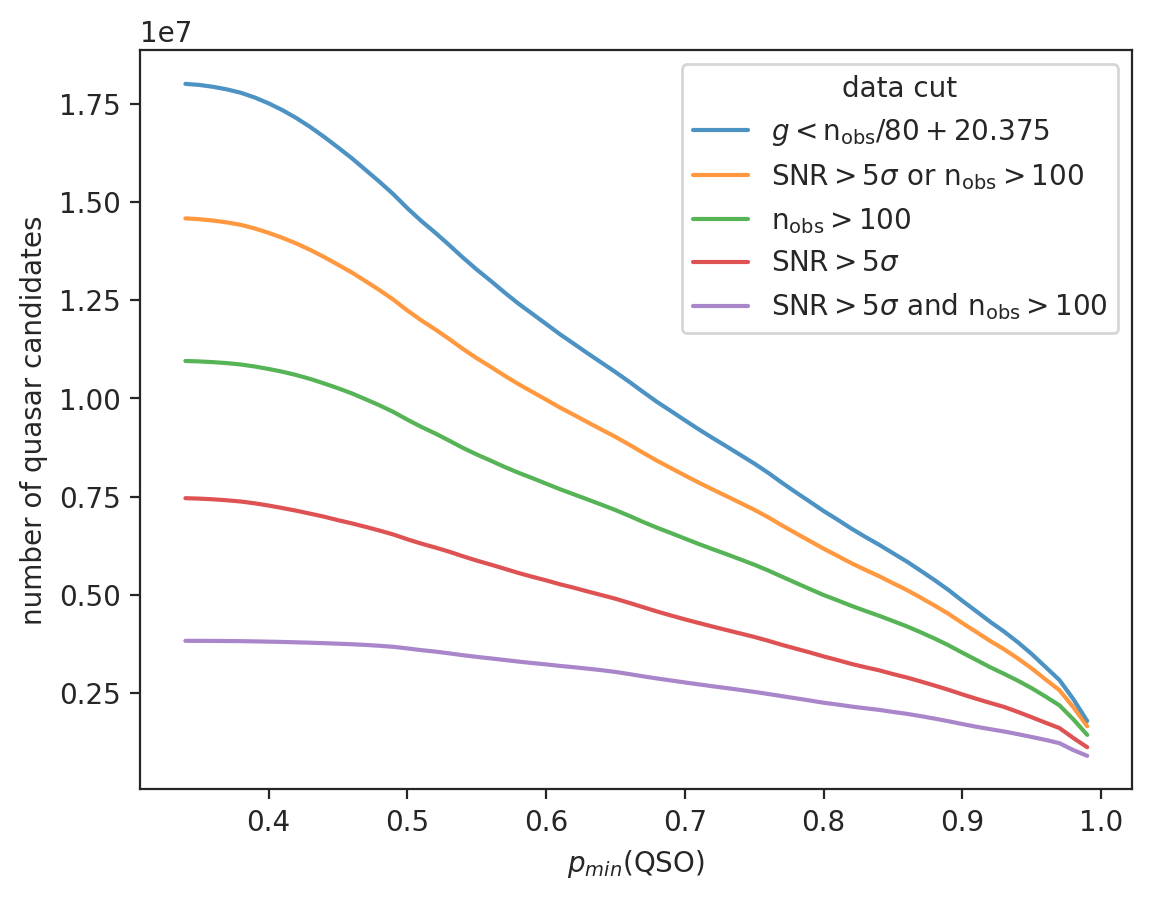

In [36]:
# WISE counts without all
idx = np.where(p_min_arr > 1/3)[0][0]

labels = {
    # 'WISE all': 'none',
    'WISE custom': '$g < \mathrm{n_{obs}} / 80 + 20.375$',
    'WISE or': '$\mathrm{SNR} > 5\sigma \mathrm{\ or\ } \mathrm{n_{obs}} > 100$',
    'WISE obs': '$\mathrm{n_{obs}} > 100$',
    'WISE mag': '$\mathrm{SNR} > 5\sigma$',
    'WISE and': '$\mathrm{SNR} > 5\sigma \mathrm{\ and\ } \mathrm{n_{obs}} > 100$',
}
for key in labels:
    print(key, n_qso[key][90])
    plt.plot(p_min_arr[idx:], n_qso[key][idx:], label=labels[key], alpha=0.8)

plt.legend(title='data cut')
plt.xlabel('$p_{min}(\mathrm{QSO})$')
plt.ylabel('number of quasar candidates')
plt.show()

combo all 6420734
combo custom 5157126
combo or 4701603
combo obs 3789465
combo mag 3029841
combo and 2117703


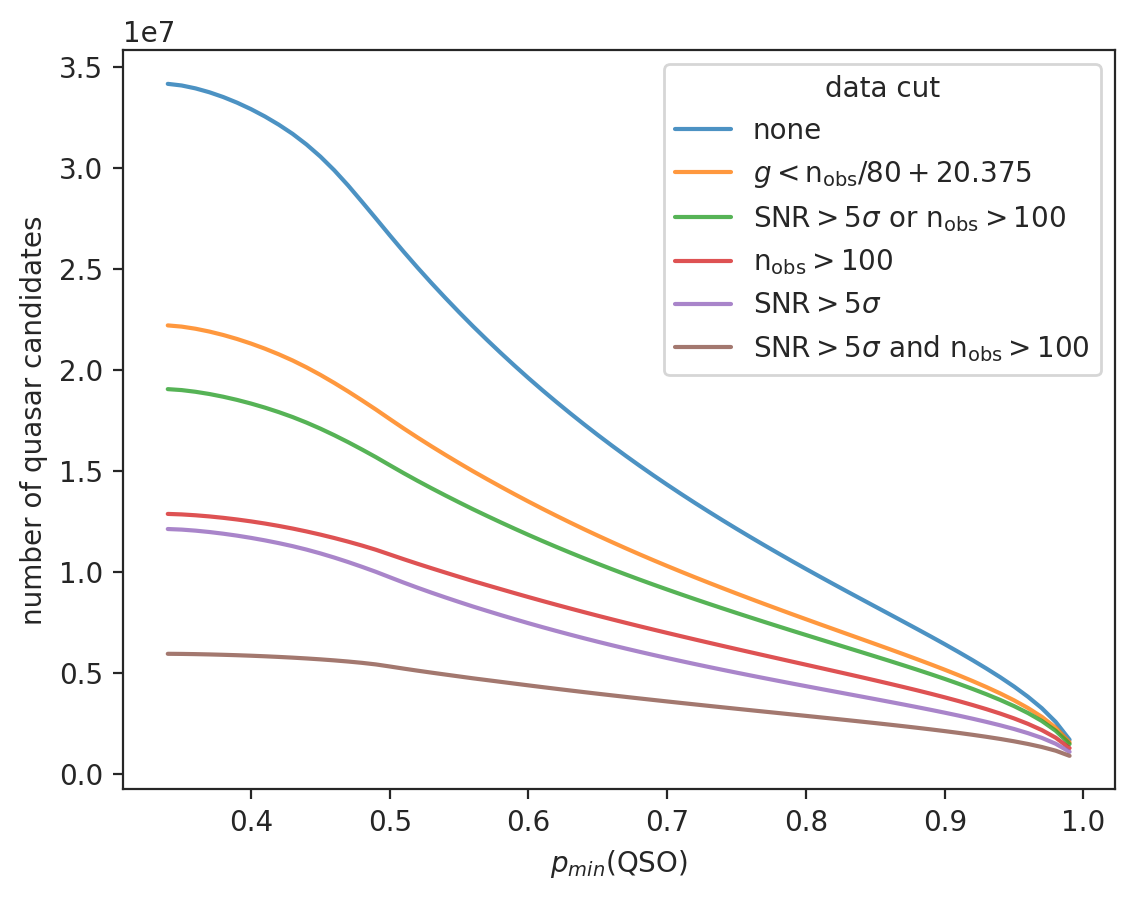

In [45]:
# Combo counts
idx = np.where(p_min_arr > 1/3)[0][0]

labels = {
    'combo all': 'none',
    'combo custom': '$g < \mathrm{n_{obs}} / 80 + 20.375$',
    'combo or': '$\mathrm{SNR} > 5\sigma \mathrm{\ or\ } \mathrm{n_{obs}} > 100$',
    'combo obs': '$\mathrm{n_{obs}} > 100$',
    'combo mag': '$\mathrm{SNR} > 5\sigma$',
    'combo and': '$\mathrm{SNR} > 5\sigma \mathrm{\ and\ } \mathrm{n_{obs}} > 100$',
}
for key in labels:
    print(key, n_qso[key][90])
    plt.plot(p_min_arr[idx:], n_qso[key][idx:], label=labels[key], alpha=0.8)

plt.legend(title='data cut')
plt.xlabel('$p_{min}(\mathrm{QSO})$')
plt.ylabel('number of quasar candidates')
plt.show()

combo custom 5157126
combo or 4701603
combo obs 3789465
combo mag 3029841
combo and 2117703


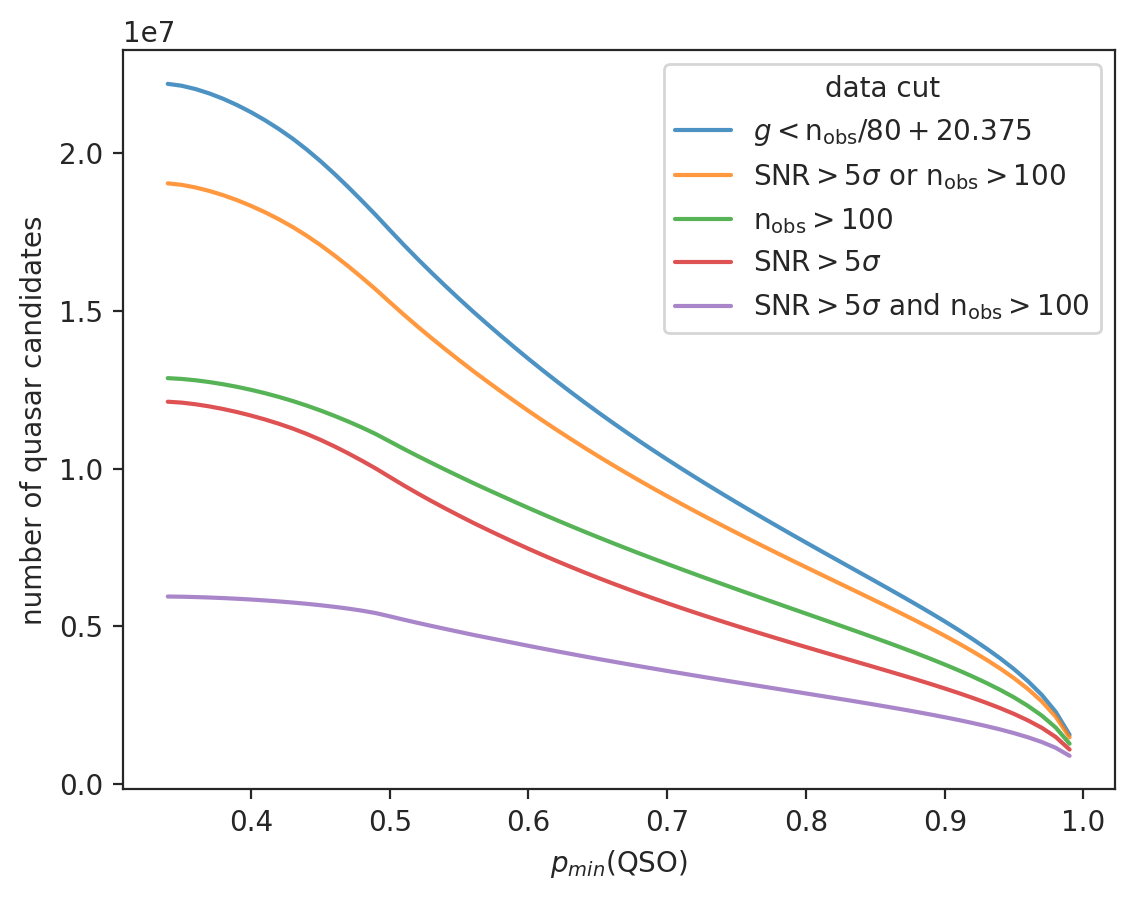

In [47]:
# Combo counts without all
idx = np.where(p_min_arr > 1/3)[0][0]

labels = {
    'combo custom': '$g < \mathrm{n_{obs}} / 80 + 20.375$',
    'combo or': '$\mathrm{SNR} > 5\sigma \mathrm{\ or\ } \mathrm{n_{obs}} > 100$',
    'combo obs': '$\mathrm{n_{obs}} > 100$',
    'combo mag': '$\mathrm{SNR} > 5\sigma$',
    'combo and': '$\mathrm{SNR} > 5\sigma \mathrm{\ and\ } \mathrm{n_{obs}} > 100$',
}
for key in labels:
    print(key, n_qso[key][90])
    plt.plot(p_min_arr[idx:], n_qso[key][idx:], label=labels[key], alpha=0.8)

plt.legend(title='data cut')
plt.xlabel('$p_{min}(\mathrm{QSO})$')
plt.ylabel('number of quasar candidates')
plt.show()

In [46]:
# Combo table
idx = np.where([x in [0.3, 0.5, 0.8, 0.9, 0.95, 0.99, 0.999] for x in p_min_arr])[0]
df = []
labels = ['combo all', 'combo custom', 'combo or', 'combo obs', 'combo mag', 'combo and']
for key in labels:
    row = {
        'data cut': key
    }
    for i in idx:
        row[p_min_arr[i]] = n_qso[key][i] / 1e6
    df.append(row)
df = pd.DataFrame(df)
print(df.to_latex(escape=False, na_rep='', float_format='%.2f', index=False))

\begin{tabular}{lrrrrrr}
\toprule
    data cut &   0.3 &   0.5 &   0.8 &  0.9 &  0.95 &  0.99 \\
\midrule
   combo all & 34.18 & 26.67 & 10.15 & 6.42 &  4.32 &  1.69 \\
combo custom & 22.21 & 17.57 &  7.66 & 5.16 &  3.64 &  1.56 \\
    combo or & 19.06 & 15.28 &  6.88 & 4.70 &  3.35 &  1.48 \\
   combo obs & 12.88 & 10.86 &  5.40 & 3.79 &  2.75 &  1.28 \\
   combo mag & 12.13 &  9.74 &  4.34 & 3.03 &  2.22 &  1.09 \\
   combo and &  5.95 &  5.32 &  2.87 & 2.12 &  1.61 &  0.89 \\
\bottomrule
\end{tabular}



/home/sjnakoneczny/workspace/ztf-agn/notebooks/ipykernel_54691/4239403999.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False, na_rep='', float_format='%.2f', index=False))


In [31]:
# WISE table
idx = np.where([x in [0.3, 0.5, 0.8, 0.9, 0.95, 0.99, 0.999] for x in p_min_arr])[0]
df = []
labels = ['WISE all', 'WISE custom', 'WISE or', 'WISE obs', 'WISE mag', 'WISE and']
for key in labels:
    row = {
        'data cut': key
    }
    for i in idx:
        row[p_min_arr[i]] = n_qso[key][i] / 1e6
    df.append(row)
df = pd.DataFrame(df)
print(df.to_latex(escape=False, na_rep='', float_format='%.2f', index=False))

\begin{tabular}{lrrrrrr}
\toprule
   data cut &   0.3 &   0.5 &   0.8 &  0.9 &  0.95 &  0.99 \\
\midrule
   WISE all & 45.93 & 32.23 & 11.26 & 6.64 &  4.50 &  2.02 \\
WISE custom & 18.01 & 14.84 &  7.14 & 4.85 &  3.50 &  1.79 \\
    WISE or & 14.59 & 12.24 &  6.18 & 4.28 &  3.13 &  1.66 \\
   WISE obs & 10.96 &  9.46 &  5.00 & 3.53 &  2.63 &  1.44 \\
   WISE mag &  7.46 &  6.42 &  3.43 & 2.47 &  1.89 &  1.12 \\
   WISE and &  3.83 &  3.64 &  2.26 & 1.71 &  1.38 &  0.90 \\
\bottomrule
\end{tabular}



/home/sjnakoneczny/workspace/ztf-agn/notebooks/ipykernel_3625073/995337302.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False, na_rep='', float_format='%.2f', index=False))


In [32]:
# WISE QSO percentage
45927239 

0.08611125221147477

In [33]:
# QZO percentage
4849574 / (788700127 - 255352419)

0.009092706178836715

# Review

## QZO magnitudes and photo-z distributions

In [5]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

cols = ['n_obs', 'mag_median']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [6]:
# Size of the full inference set
preds_ztf.shape

(788700127, 2)

In [7]:
# Read ZTF duplicates
path_dups = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_dups.csv'.format(ztf_date, ztf_date, filter)
path_dups = os.path.join(STORAGE_PATH, path_dups)

cols = ['is_duplicate']
preds_dups = pd.read_csv(path_dups, usecols=cols)

In [8]:
preds_dups['is_duplicate'].sum()

255352419

In [9]:
# Read WISE preds
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_galaxy', 'y_qso', 'y_star', 'z_pred']
preds_xgb = pd.read_csv(path_xgb, usecols=cols)

In [10]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols)

In [11]:
# Get the subset indices
idx = (
    (preds_dups['is_duplicate'] == False) &
    ((preds_xgb['y_galaxy'] > 0.9) | (preds_xgb['y_qso'] > 0.9) | (preds_xgb['y_star'] > 0.9)) &
    # (preds_xgb['y_qso'] > 0.4) &
    (preds_ztf['mag_median'] < (preds_ztf['n_obs'] / 80 + 20.375))
)

In [12]:
idx.sum()

300996207

In [13]:
preds_dups = 0
gc.collect()

70

In [14]:
# Merge all in little turns
preds = preds_ztf[idx].join(preds_xgb[idx])
preds_ztf = 0
preds_xgb = 0
gc.collect()

0

In [15]:
preds = preds.join(preds_wise[idx])
preds_wise = 0
gc.collect()

0

In [16]:
preds = preds.reset_index(drop=True)

In [17]:
gc.collect()

0

### Magnitudes

In [20]:
preds.shape

(300996207, 10)

In [31]:
# Pick a random subsample
preds_subset = preds  # preds.sample(n=int(1e7), random_state=None)

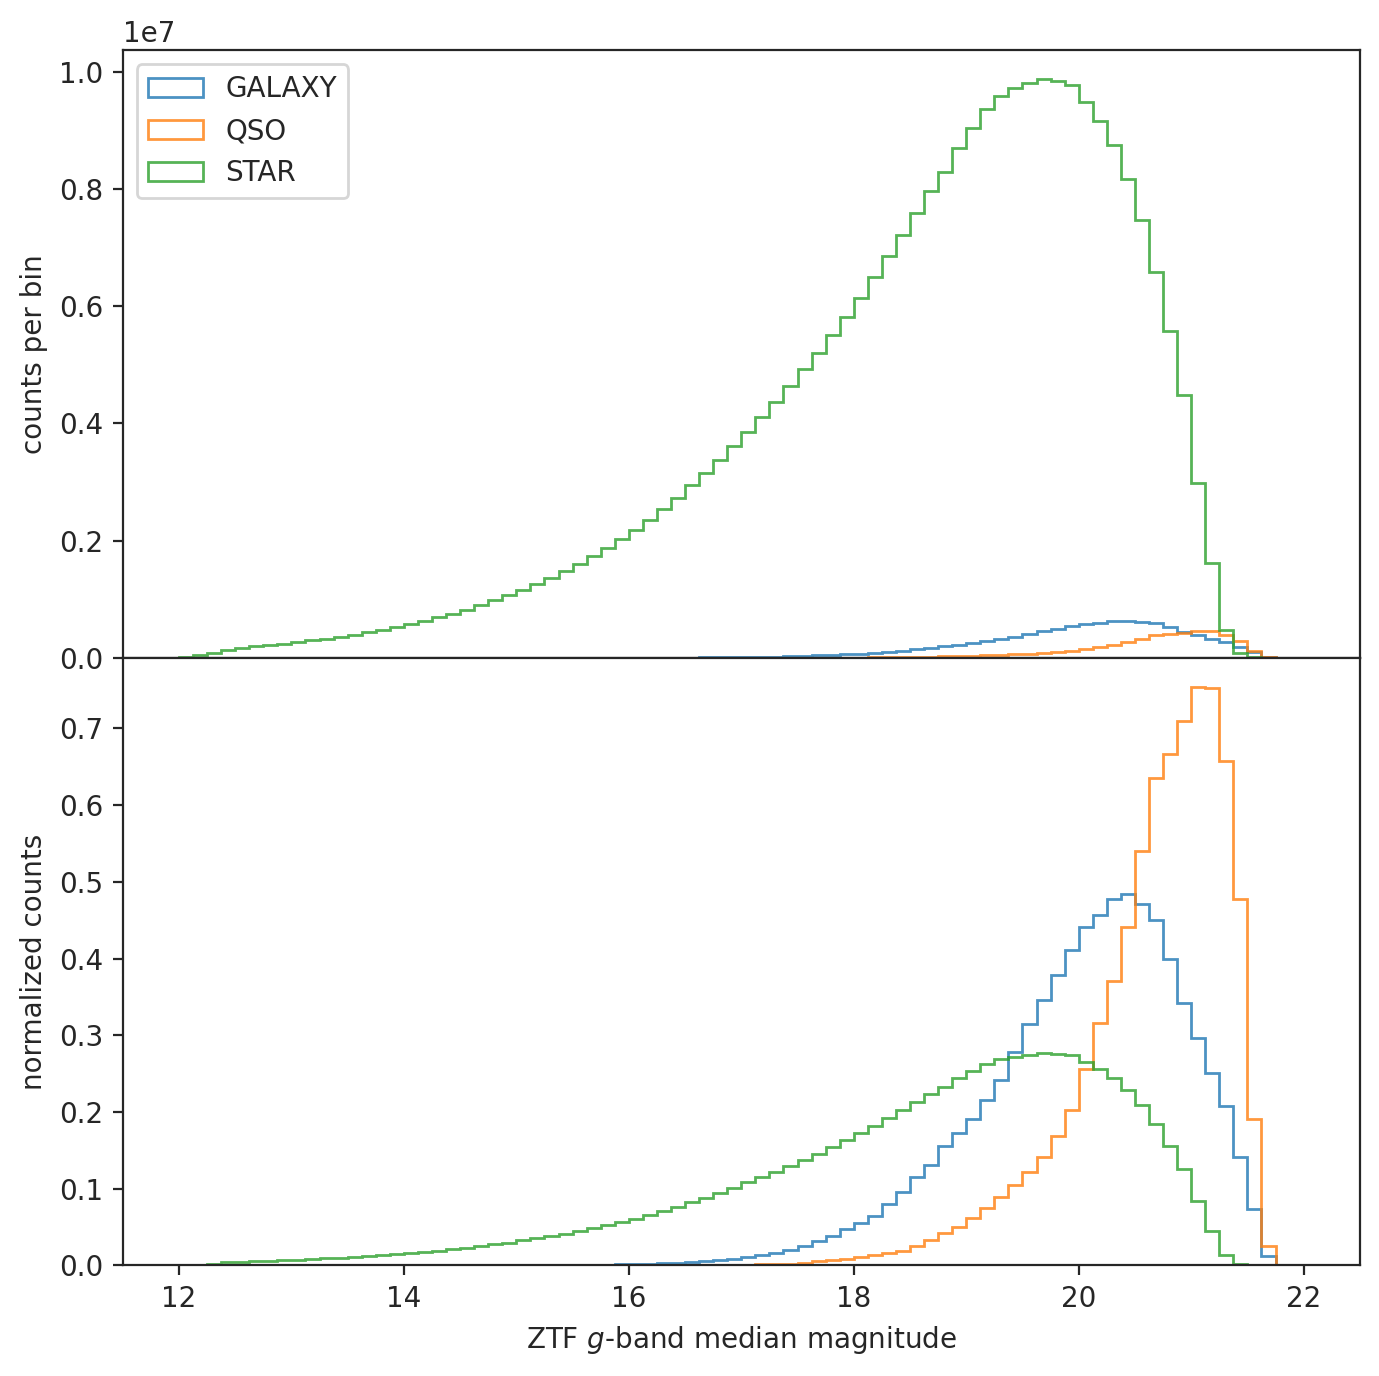

In [32]:
range = (12, 22)
n_bins = 80

fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(2, 1, hspace=0)
axs = gs.subplots(sharex=True)

for i in [0, 1]:
    # Classes
    for cls_name in ['GALAXY', 'QSO', 'STAR']:
        data_cls = preds_subset[preds_subset['y_{}'.format(cls_name.lower())] > 0.9]
        vals_cls = data_cls['mag_median']

        axs[i].hist(vals_cls, label=cls_name, range=range, bins=n_bins, density=i,
                     histtype='step', log=False, alpha=0.8)    
    if i == 0:
        axs[i].legend()

    axs[i].set_xlabel('ZTF $g$-band median magnitude')
    if i:
         axs[i].set_ylabel('normalized counts')
    else:
         axs[i].set_ylabel('counts per bin')

for ax in axs:
    ax.label_outer()

plt.tight_layout()
plt.show()

### Photo-zs

In [18]:
# Get the QZO
qzo = preds.loc[preds['y_qso'] > 0.5]

In [19]:
qzo.shape

(14840719, 10)

In [20]:
# Get the WISE subset
cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
nan_mask = qzo[cols].isna().any(axis=1)
qzo_wise = qzo.loc[~nan_mask]

In [21]:
qzo_wise.shape

(3252214, 10)

In [22]:
# Pick a random subsample
# qzo_wise_subset = qzo_wise.sample(n=int(1e5), random_state=None)

In [23]:
qzo_wise['z_pred'].min()

-0.46469015

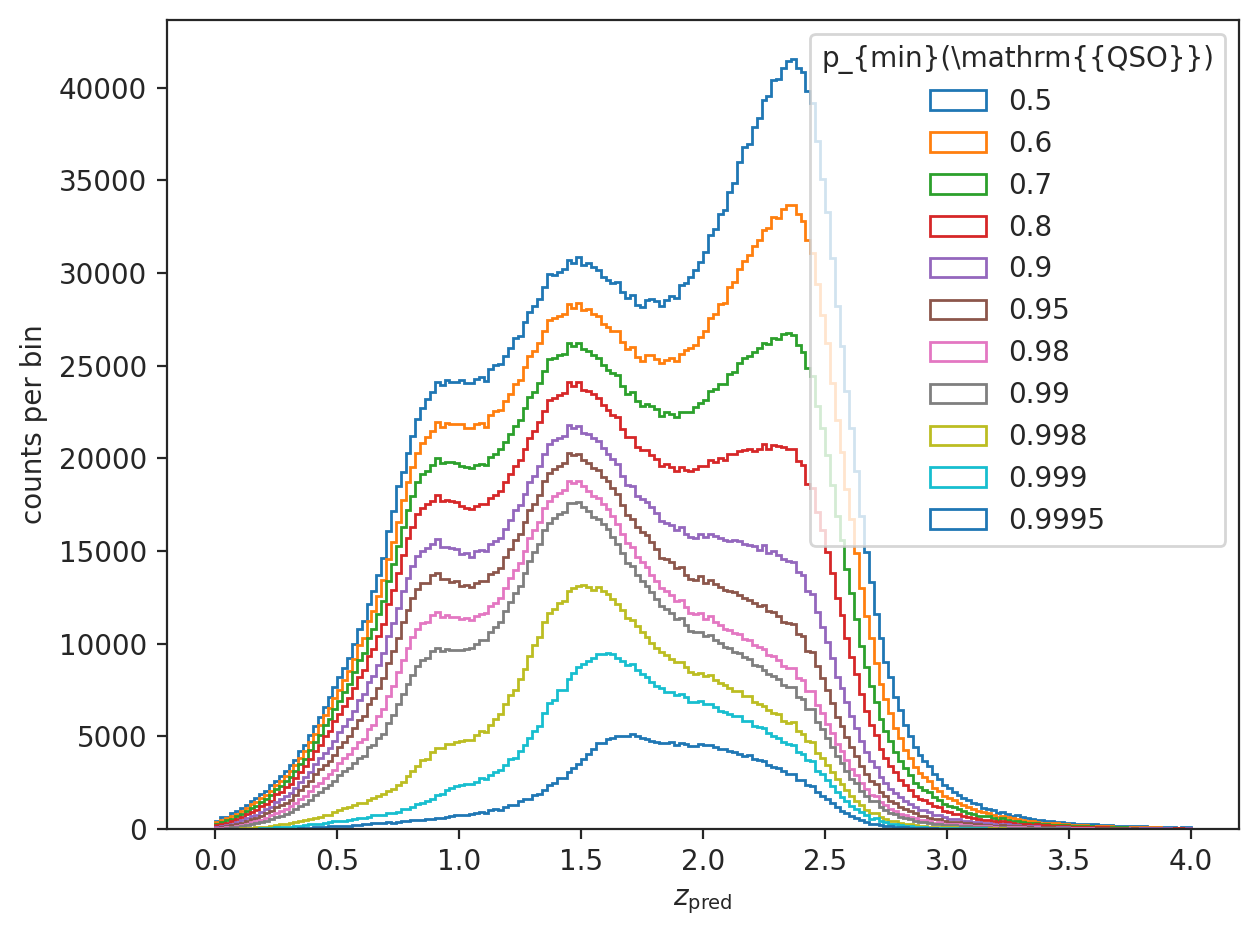

In [24]:
# Plot the distribution
range = (0, 4)
bins = 200

for min_proba in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 0.998, 0.999, 0.9995]:
    subset = qzo_wise.loc[qzo_wise['y_qso'] > min_proba]
    label = min_proba
    plt.hist(subset['z_pred'], label=label, density=False, range=range, bins=bins, histtype='step', log=False)

plt.xlabel('$z_\mathrm{pred}$')
plt.ylabel('counts per bin')
plt.legend(title='p_{min}(\mathrm{{QSO}})')
plt.tight_layout()
plt.show()

## WISE bands coverage

In [5]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols)

In [6]:
preds_wise.shape

(788700127, 4)

In [10]:
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
nan_indices = preds_wise.index[preds_wise.isna()[wise_cols].any(axis=1)]
len(nan_indices)

465842833

In [11]:
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro']
nan_indices = preds_wise.index[preds_wise.isna()[wise_cols].any(axis=1)]
len(nan_indices)

465811305

In [12]:
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro']
nan_indices = preds_wise.index[preds_wise.isna()[wise_cols].any(axis=1)]
len(nan_indices)

465581251

In [13]:
wise_cols = ['AllWISE__w1mpro']
nan_indices = preds_wise.index[preds_wise.isna()[wise_cols].any(axis=1)]
len(nan_indices)

465580753

In [21]:
full = 788700127
w4 = 465842833
w3 = 465811305
w2 = 465581251
w1 = 465580753

In [23]:
for x in [w4, w4, w3, w1]:
    print(1 - (x / full))

0.4093536731483245
0.4093536731483245
0.40939364778370324
0.40968596674259194


In [26]:
# Original AllWISE catalog
data_wise = pd.read_csv('~/data/AllWISE/AllWISE.csv', usecols=['w1mpro', 'w2mpro', 'w3mpro', 'w4mpro'])

In [27]:
data_wise.shape

(747634026, 4)

In [28]:
wise_cols = ['w1mpro', 'w2mpro', 'w3mpro', 'w4mpro']
nan_indices = data_wise.index[data_wise.isna()[wise_cols].any(axis=1)]
len(nan_indices)

521784

In [29]:
wise_cols = ['w1mpro', 'w2mpro', 'w3mpro']
nan_indices = data_wise.index[data_wise.isna()[wise_cols].any(axis=1)]
len(nan_indices)

458600

In [30]:
wise_cols = ['w1mpro', 'w2mpro']
nan_indices = data_wise.index[data_wise.isna()[wise_cols].any(axis=1)]
len(nan_indices)

13439

In [31]:
wise_cols = ['w1mpro']
nan_indices = data_wise.index[data_wise.isna()[wise_cols].any(axis=1)]
len(nan_indices)

10327

In [32]:
full = 747634026
w4 = 521784
w3 = 458600
w2 = 13439
w1 = 10327

In [33]:
for x in [w4, w4, w3, w1]:
    print(1 - (x / full))

0.9993020863392325
0.9993020863392325
0.9993865982766279
0.9999861870920251


## Bimodal galaxies in training

In [5]:
from sdss import read_sdss

In [8]:
data_sdss = read_sdss(dr=18, clean=True, columns=None, n=None, return_cross_matches=False)

ValueError: Cannot convert a table with multidimensional columns to a pandas DataFrame. Offending columns are: ['OBJID', 'TCOLUMN', 'THETA', 'SN_MEDIAN', 'FRACNSIGMA', 'FRACNSIGHI', 'FRACNSIGLO', 'SPECTROFLUX', 'SPECTROFLUX_IVAR', 'SPECTROSYNFLUX', 'SPECTROSYNFLUX_IVAR', 'SPECTROSKYFLUX', 'CALIBFLUX', 'CALIBFLUX_IVAR']
One can filter out such columns using:
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
tbl[names].to_pandas(...)

In [ ]:
data_sdss.columns

## Magnitudes vs errors

In [5]:
ztf_date = ZTF_DATES['DR 20']
filter = 'g'

In [6]:
# Read the train data
light_curves, data = get_train_data(ztf_date=ztf_date, filter=filter, return_light_curves=True)

In [7]:
# Add lightcurve stats
file_name = 'ZTF_x_SDSS/ZTF_{}/ztf_{}_x_specObj-dr18__longests_filter_{}_reduced__stats'.format(
    ztf_date, ztf_date, filter)
path = os.path.join(DATA_PATH, file_name)
with open(path, 'rb') as file:
    df = pickle.load(file)
    data = pd.concat([data, df], axis=1)

In [21]:
data['mag err abs mean'] = [np.mean(np.abs(lc_dict['magerr'])) for lc_dict in tqdm(light_curves)]

  0%|          | 0/2588221 [00:00<?, ?it/s]

In [26]:
df

,mag median,mag err mean,n obs,timespan,cadence mean,cadence median,cadence plus sigma,cadence minus sigma
0,20.371018,0.139685,40,1900.794090,48.738310,5.009330,16.890101,4.004243
1,20.371018,0.139685,40,1900.794090,48.738310,5.009330,16.890101,4.004243
2,20.877720,0.161991,41,1565.785815,39.144645,4.526745,16.447866,3.516247
3,19.121345,0.055191,444,1981.813530,4.473620,2.014300,2.877631,1.013931
4,18.387285,0.032307,462,1981.813520,4.298945,2.006380,2.025736,1.006256
...,...,...,...,...,...,...,...,...
2588216,21.372540,0.215129,168,1958.837700,11.729567,2.966060,9.445324,1.951768
2588217,20.040739,0.102786,464,1970.696050,4.256363,1.101620,2.906000,0.127929
2588218,20.630938,0.155563,290,1968.852570,6.812639,2.921410,4.078739,1.913590
2588219,17.932935,0.027726,276,1965.800590,7.148366,3.001960,3.943966,1.098499


In [30]:
file_name = 'ZTF_x_SDSS/ZTF_{}/ztf_{}_x_specObj-dr18__longests_filter_{}_reduced__stats'.format(
    ztf_date, ztf_date, filter)
path = os.path.join(DATA_PATH, file_name)
with open(path, 'wb') as file:
    pickle.dump(df, file)

<Figure size 640x480 with 0 Axes>

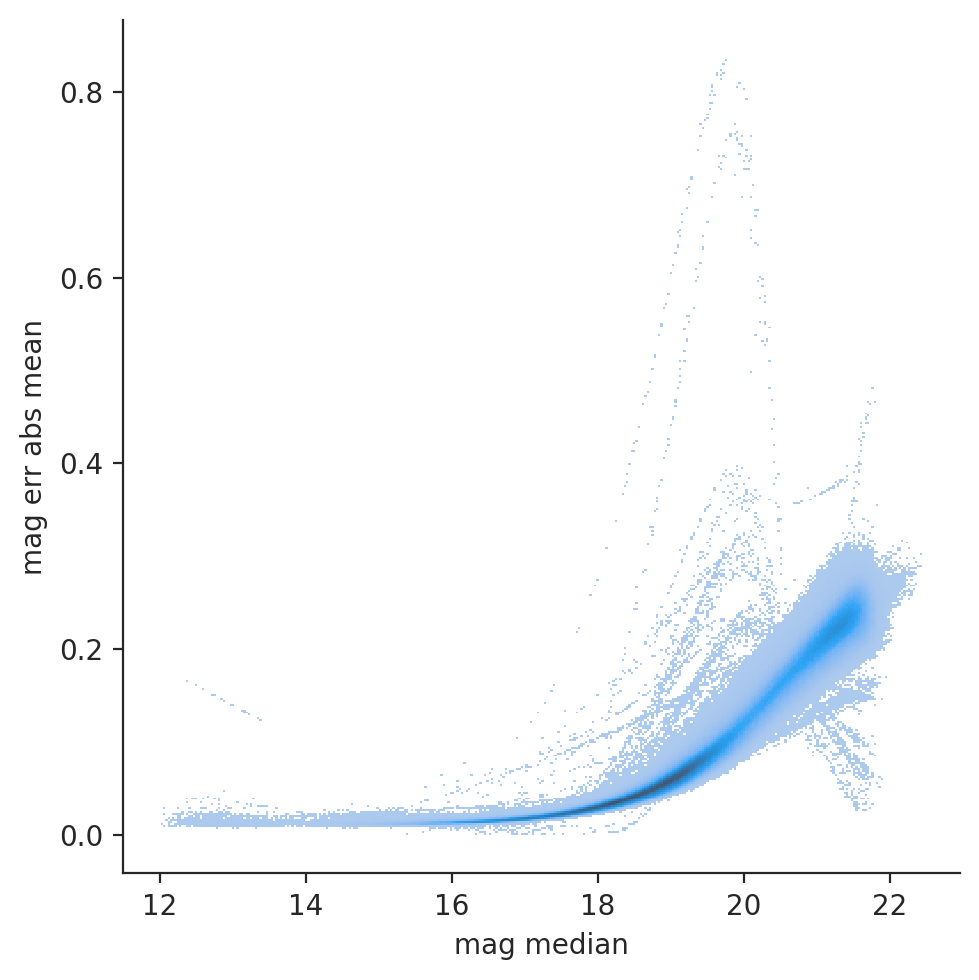

<Figure size 640x480 with 0 Axes>

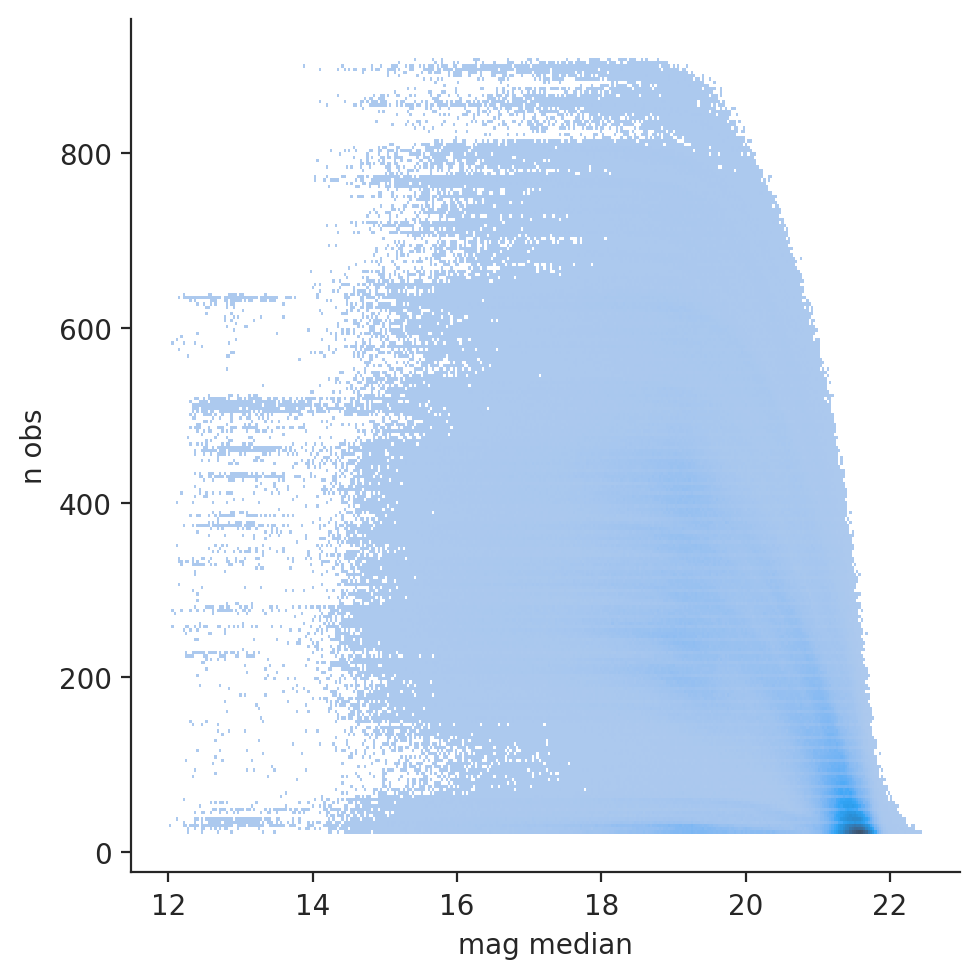

<Figure size 640x480 with 0 Axes>

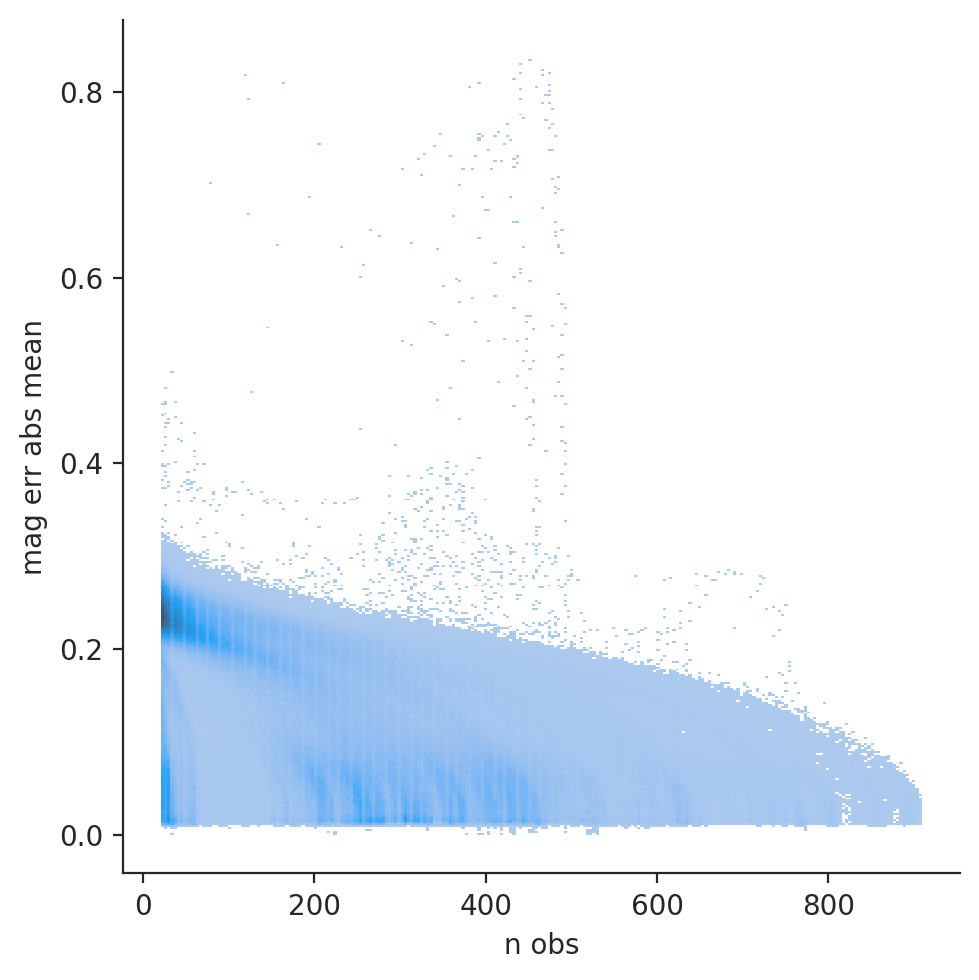

<Figure size 640x480 with 0 Axes>

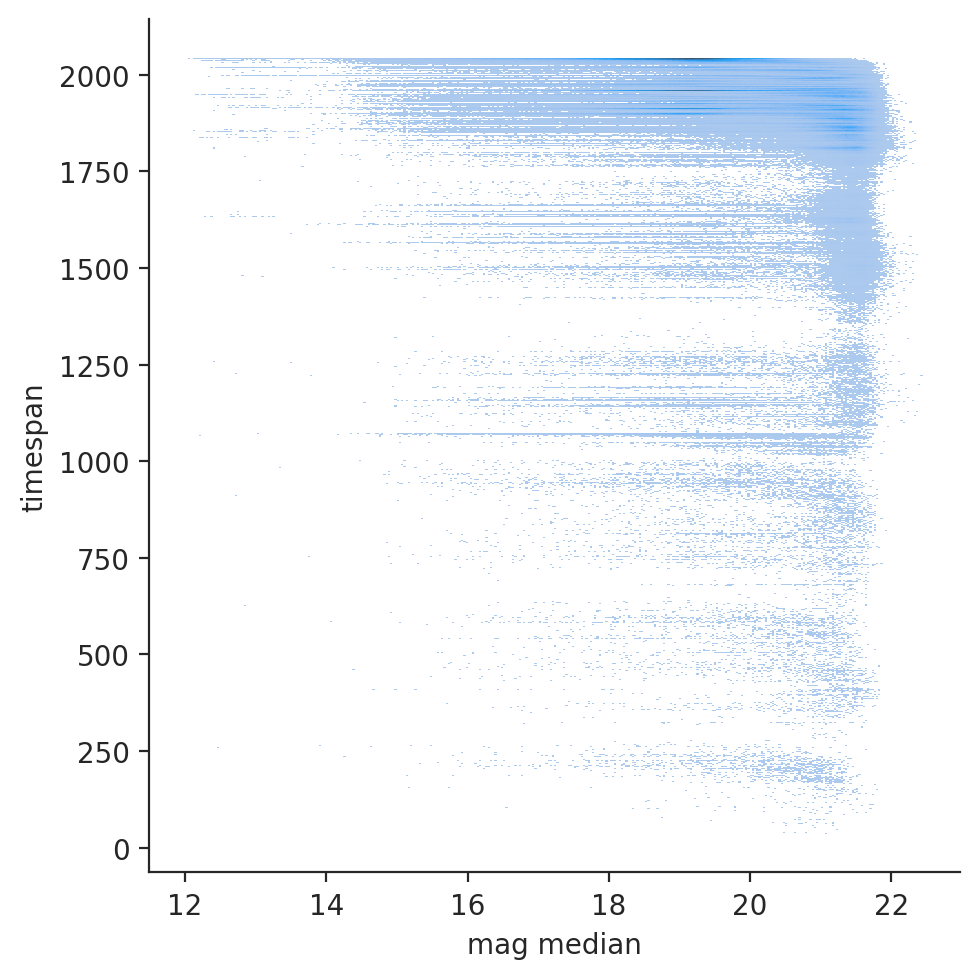

<Figure size 640x480 with 0 Axes>

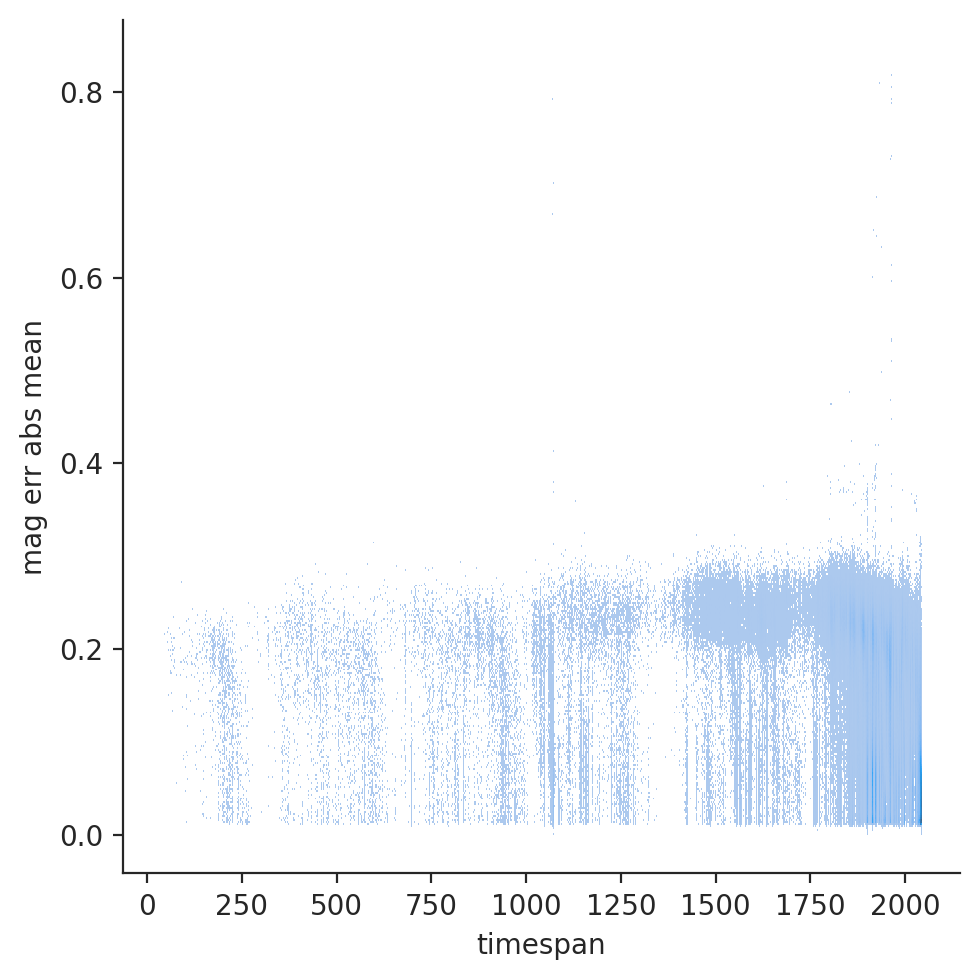

<Figure size 640x480 with 0 Axes>

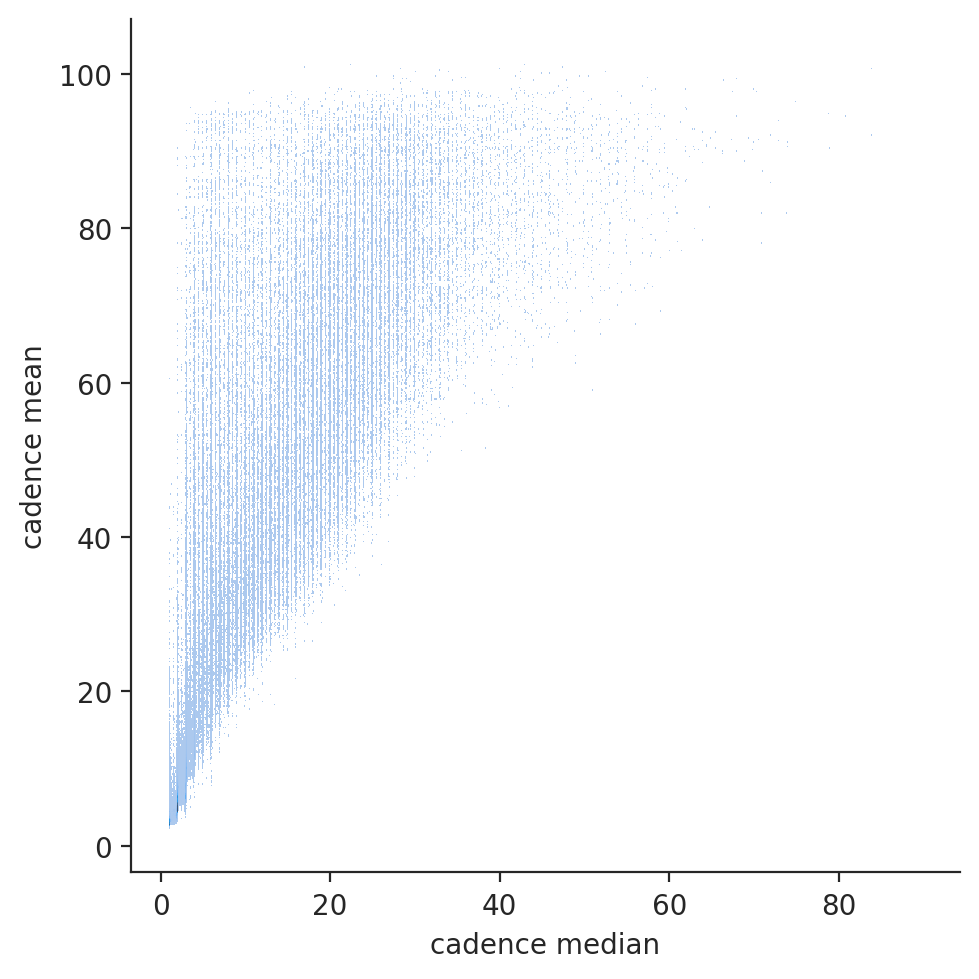

<Figure size 640x480 with 0 Axes>

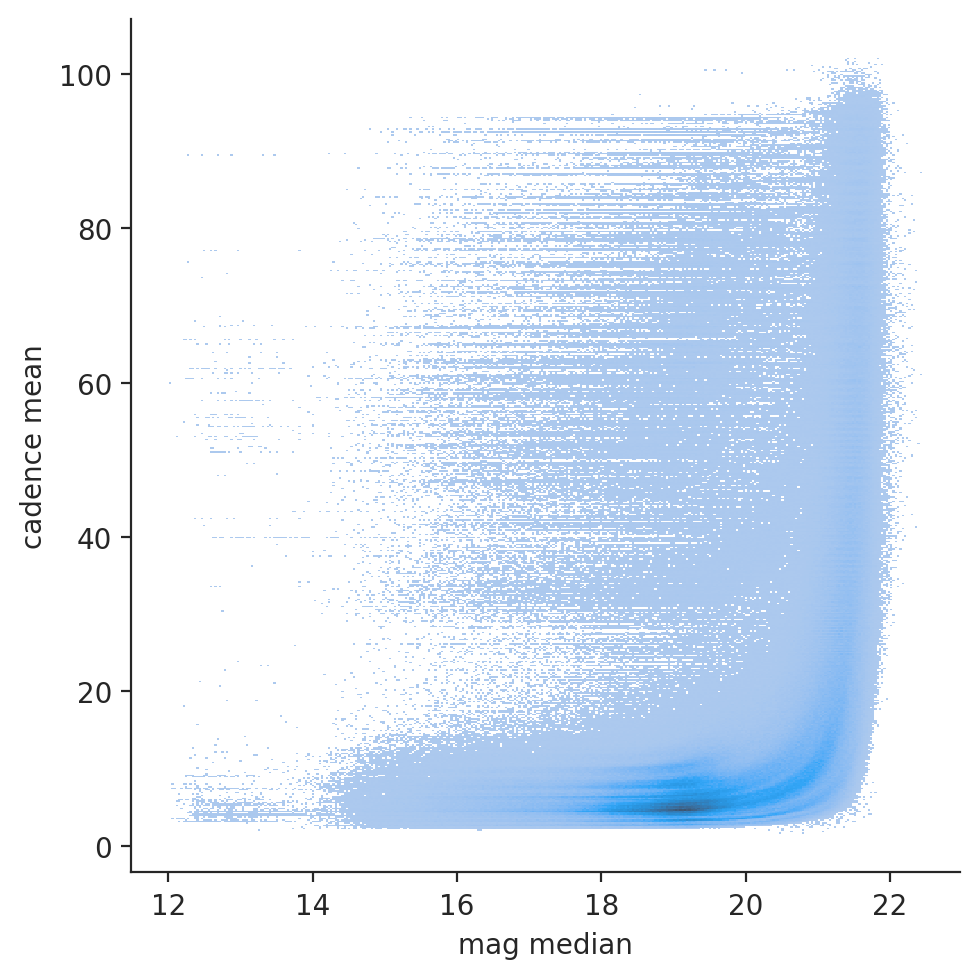

<Figure size 640x480 with 0 Axes>

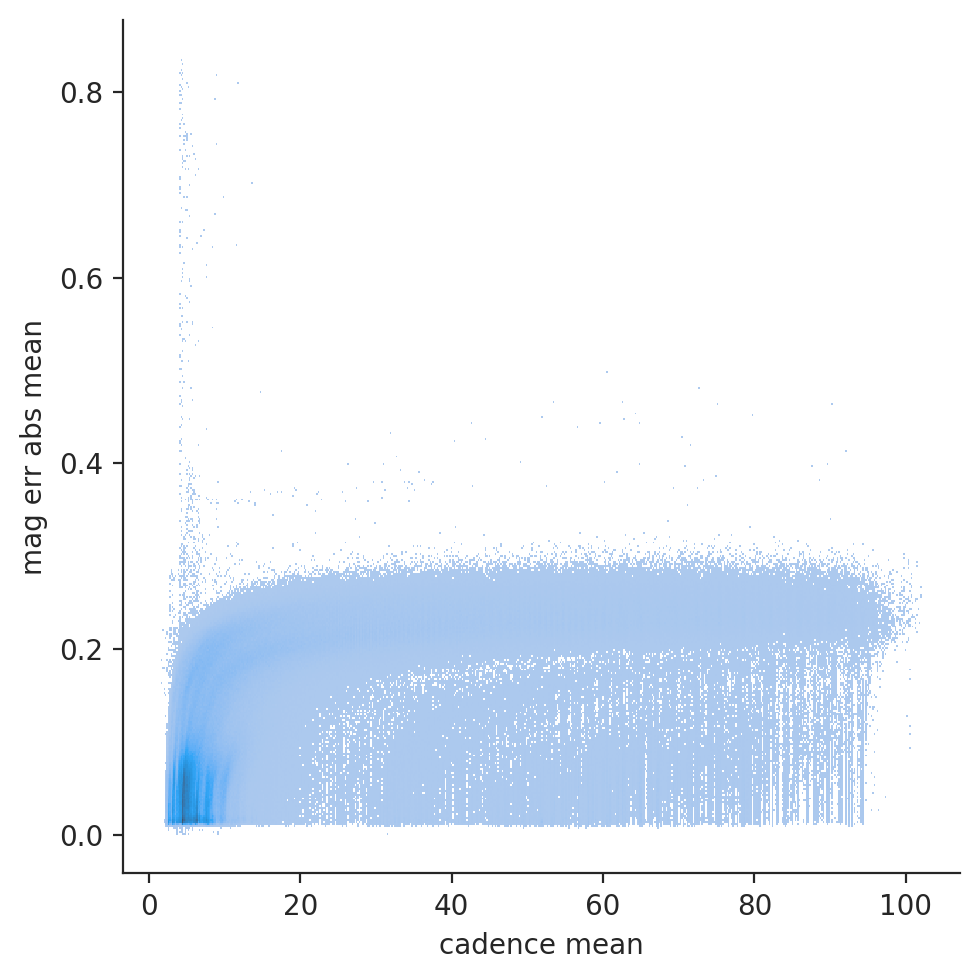

In [25]:
for x, y in [
    ('mag median', 'mag err abs mean'),
    ('mag median', 'n obs'),
    ('n obs', 'mag err abs mean'),
    ('mag median', 'timespan'),
    ('timespan', 'mag err abs mean'),
    ('cadence median', 'cadence mean'),
    ('mag median', 'cadence mean'),
    ('cadence mean', 'mag err abs mean'),
]:
    plt.figure()
    sns.displot(data=data, x=x, y=y)
    plt.show()